# R notebook to run Scaled Poisson Model on synthetic data
Authors: Mudassar Iqbal, Syed Murtuza Baker, Adam Farooq, Magnus Rattray

Date: 18 Jan 23

# Input Data
Some detail of the Input data

## Functions for plotting/visualisation

In [1]:
# Core Packages needed in different places
library(prabclus,lib.loc='~/R/x86_64-pc-linux-gnu-library/4.0')
#library(prabclus)
library(cluster)
library(ggplot2)
library(mclust)
library(Matrix)

Loading required package: MASS

Loading required package: mclust

Package 'mclust' version 5.4.6
Type 'citation("mclust")' for citing this R package in publications.



In [79]:
sessionInfo()

R version 4.0.2 (2020-06-22)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS:   /opt/R-4.0.2/lib64/R/lib/libRblas.so
LAPACK: /opt/R-4.0.2/lib64/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_GB.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_GB.UTF-8        LC_COLLATE=en_GB.UTF-8    
 [5] LC_MONETARY=en_GB.UTF-8    LC_MESSAGES=en_GB.UTF-8   
 [7] LC_PAPER=en_GB.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_GB.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
[1] Signac_1.0.0   Seurat_3.2.2   Matrix_1.2-18  ggplot2_3.3.2  cluster_2.1.0 
[6] prabclus_2.3-2 mclust_5.4.6   MASS_7.3-51.6 

loaded via a namespace (and not attached):
  [1] reticulate_1.16             tidyselect_1.1.0           
  [3] RSQLite_2.2.1               Annotat

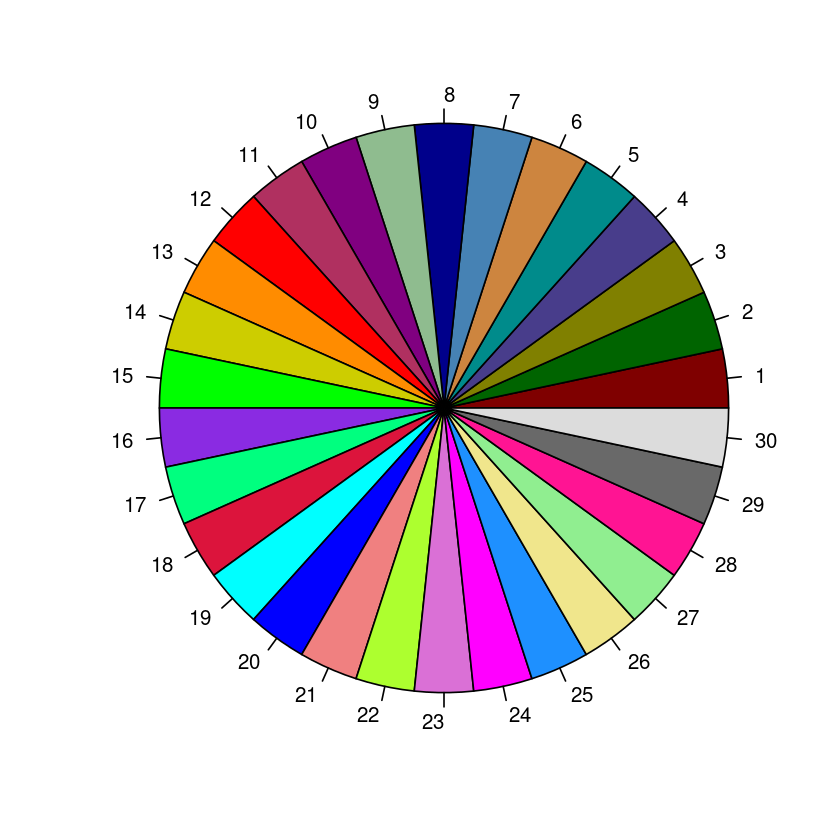

In [2]:
c30 <- c(

        "#7f0000", # maroon2

        "#006400", # darkgreen

        "#808000", # olive

        "#483d8b", # darkslateblue

        "#008b8b", # darkcyan

        "#cd853f", # peru

        "#4682b4", # steelblue

        "#00008b", # darkblue

        "#8fbc8f", # darkseagreen

        "#800080", # purple

        "#b03060", # maroon3

        "#ff0000", # red

        "#ff8c00", # darkorange

        "#cdcd00", # yellow3

        "#00ff00", # lime

        "#8a2be2", # blueviolet

        "#00ff7f", # springgreen

        "#dc143c", # crimson

        "#00ffff", # aqua

        "#0000ff", # blue

        "#f08080", # lightcoral

        "#adff2f", # greenyellow

        "#da70d6", # orchid

        "#ff00ff", # fuchsia

        "#1e90ff", # dodgerblue

        "#f0e68c", # khaki

        "#90ee90", # lightgreen

        "#ff1493", # deeppink

        "#696969", # dimgray

        "#dcdcdc"  # gainsboro

)

pie(rep(1,30), col = c30, radius = 1)

## Plotting utils

In [3]:
## Calculating Jaccard Distance
getJaccardDist <- function(cdBinary){        
    if(colnames(cdBinary[,2:3])[1] == 'start' & colnames(cdBinary[,2:3])[2] == 'end'){
        SingleCell.Binary <- cdBinary[,4:(dim(cdBinary)[2])]
    }
    else    
    SingleCell.Binary <- cdBinary 
    SingleCell.Binary.Jaccard <- jaccard(as.matrix(SingleCell.Binary))
    return(SingleCell.Binary.Jaccard)
}

In [4]:
## MDS plot function
plotMDS <- function(cdBinary, k, groups=NULL, cellName, ret.val=FALSE, text.label=FALSE, 
                    title="", coordinates=c(1,2)){
    if(missing(ret.val)){
        ret.val = FALSE
    }
    if(text.label==TRUE & missing(cellName)){
        stop("ERROR: Please give cellName")
    }
    
    SingleCell.Binary.Jaccard <- getJaccardDist(cdBinary)
    fit <- cmdscale(as.dist(SingleCell.Binary.Jaccard),eig=TRUE, k=k)

 
    if(is.null(groups)){
        df<-data.frame(x=fit$points[,coordinates[1]],y=fit$points[,coordinates[2]], Cell=colnames(SingleCell.Binary.Jaccard))
        p <- ggplot(df, aes_string(x="x",y ="y"))+ scale_colour_hue(l=40)
    }
    else{
        df<-data.frame(x=fit$points[,coordinates[1]],y=fit$points[,coordinates[2]], Cell=colnames(SingleCell.Binary.Jaccard), Batch=groups)
         p <- ggplot(df, aes_string(x="x",y ="y", color="Batch"))+ 
            scale_colour_hue(l=40) + 
            scale_colour_brewer(palette="Set1") 
    }

    
    p <- p + ggtitle(title) + theme(plot.title = element_text(size = 20, face = "bold"))
    p <- p + geom_point(size = 2)
    p <- p + xlab(paste0("Coordinate ",coordinates[1])) 
    p <- p + ylab(paste0("Coordinate ",coordinates[2]))+
	theme_light(base_size=24) +
        theme(strip.background = element_blank(),
              panel.border     = element_blank(),
              plot.title = element_text(hjust = 0.5))

       
    if(text.label==TRUE)
        p <- p + geom_text(data=df,aes(label=cellName),alpha=0.5,size=4, vjust=1,hjust=0.5,angle=45)
    print(p)
    if(ret.val == TRUE)
        return(fit)
}

In [5]:
## Sequencing Depth plot
plotMDSCellDepth <- function(cdBinary, k, cellDepth=NULL, cellName, ret.val=FALSE, text.label=FALSE, 
                    title="", coordinates=c(1,2)){
    if(missing(ret.val)){
        ret.val = FALSE
    }
    if(text.label==TRUE & missing(cellName)){
        stop("ERROR: Please give cellName")
    }    
    SingleCell.Binary.Jaccard <- getJaccardDist(cdBinary)
    fit <- cmdscale(as.dist(SingleCell.Binary.Jaccard),eig=TRUE, k=k)

    if(is.null(cellDepth)){
        df<-data.frame(x=fit$points[,coordinates[1]],y=fit$points[,coordinates[2]], Cell=colnames(SingleCell.Binary.Jaccard))
        p <- ggplot(df, aes_string(x="x",y ="y"))
    }
    else{
        df<-data.frame(x=fit$points[,coordinates[1]],y=fit$points[,coordinates[2]], Cell=colnames(SingleCell.Binary.Jaccard), cellDepth=cellDepth)
         p <- ggplot(df, aes_string(x="x",y ="y", color="cellDepth")) + 
  scale_colour_gradientn(colours = c("blue", "yellow2", "red"))
    }
    
    p <- p + ggtitle(title) + theme(plot.title = element_text(size = 20, face = "bold"))
    p <- p + geom_point(size = 2)
    p <- p + xlab(paste0("Coordinate ",coordinates[1])) 
    p <- p + ylab(paste0("Coordinate ",coordinates[2]))+
	theme_light(base_size=24) +
        theme(strip.background = element_blank(),
              panel.border     = element_blank(),
              plot.title = element_text(hjust = 0.5))
    
    if(text.label==TRUE)
        p <- p + geom_text(data=df,aes(label=cellName),alpha=0.5,size=4, vjust=1,hjust=0.5,angle=45)

    print(p)
}

In [6]:
## MDS plot for clusters
plotMDSClust <- function(cdBinary, k, Clusters=NULL, cellName, ret.val=FALSE, text.label=FALSE, 
                    title=""){
    if(missing(k)){
        stop("ERROR: Number of Clusters \"k\" is missing")
    }
    if(missing(ret.val)){
        ret.val = FALSE
    }
    if(text.label==TRUE & missing(cellName)){
        stop("ERROR: Please give cellName")
    }    
    SingleCell.Binary.Jaccard <- getJaccardDist(cdBinary)
    fit <- cmdscale(as.dist(SingleCell.Binary.Jaccard),eig=TRUE, k=k)
 
    if(is.null(Clusters)){
        df<-data.frame(x=fit$points[,1],y=fit$points[,2], Cell=colnames(SingleCell.Binary.Jaccard))
        p <- ggplot(df, aes_string(x="x",y ="y"))+ scale_colour_hue(l=40)
    }
    else{
        df<-data.frame(x=fit$points[,1],y=fit$points[,2], Cell=colnames(SingleCell.Binary.Jaccard), Clusters=Clusters)
        p <- ggplot(df, aes_string(x="x",y ="y", color="Clusters"))+ scale_colour_hue(l=40)
    }
  
    p <- p + ggtitle(title) + theme(plot.title = element_text(size = 20, face = "bold"))
    p <- p + geom_point(size = 2)
    p <- p + xlab("Coordinate 1") 
    p <- p + ylab("Coordinate 2")+
	theme_light(base_size=24) +
        theme(strip.background = element_blank(),
              panel.border     = element_blank(),
              plot.title = element_text(hjust = 0.5))

    if(length(levels(Clusters)) < 12)
        p <- p + scale_colour_brewer(palette="Set1")        
    if(text.label==TRUE)
        p <- p + geom_text(data=df,aes(label=cellName),alpha=0.5,size=4, vjust=1,hjust=0.5,angle=45)

    print(p)
}


In [7]:
# multiplot function
multiplot <- function(..., plotList=NULL, File, cols=1, layout=NULL) {
  # Adopted from Cookbook for R
  library(grid)
  plots <- c(list(...), plotList)
  numPlots = length(plots)
  if (is.null(layout)) {
    layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
                    ncol = cols, nrow = ceiling(numPlots/cols))
  }
 if (numPlots==1) {
    print(plots[[1]])

  } else {
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))
    # Make each plot, in the correct location
    for (i in 1:numPlots) {
      # Get the i,j matrix positions of the regions that contain this subplot
      matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))

      print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                      layout.pos.col = matchidx$col))
    }
  }
}

# Sub-routines for scaled Poisson method

In [80]:
## Scaled Poisson EM (E-step calculation)
compute_z <- function(){   
  # Global variables used in this function  
  # max_z_idx  - cell cluster labels
  # lambda_i_k - parameters for mixtures (clusters, dimension = clusters x peaks)
  # N - number of cells
  # K - number of clusters (mixture components)
  # x - data matrix (rows = cells, columns = peaks) 
  # x_sel - index of selected peaks through feature selection
  weights <- rep(0,K)
  for (k in 1:K){
    weights[k] <- sum(max_z_idx==k)/N      
  }  
	lambda_i_k[lambda_i_k<EPS] = EPS  # EPS is small value (globally defined)
	z_temp <- matrix( data = 0, nrow = N, ncol = K, byrow = T )
	for(i in 1:N){
	  for(j in 1:K){
	    z_temp[i,j] <- log(weights[j]) +     
	                   sum(x[i,x_sel]*log(lambda_i_k[j,1:length(x_sel)]*alpha[i]+EPS) - 
                        (lambda_i_k[j,1:length(x_sel)]*alpha[i]+EPS) )
                           #- log(factorial(x[i,x_sel])+EPS)) # Not needed here
	                   
	  }
    }
return(z_temp)
}

In [9]:
## Calculate Y_i(gain in likelihood for every peak---Used for feature selection)
calc_Y_i <- function(){   # calculating Y_i for individual peaks, using hard EM version for z update (E-step)
  # max_z_idx  - cluster labels
  # lambda_i_k - parameters for mixtures (clusters)
  # lambda_i_0  - parameters when there is only one cluster in the data 
  # alpha  - relative sequencing depth (vector with length equal to number of cells)
  
    
  lambda_i_k[lambda_i_k<EPS] = EPS  
  
  # calculate Y-i for each peak
  Y <- matrix(0,nrow=D,1) 
  for (i in 1:D){
      Y[i,1] <- sum( x[,i]*(log(alpha*lambda_i_k[max_z_idx,i]+EPS)-log(alpha*lambda_i_0[i]+EPS) )  
                    - (alpha*lambda_i_k[max_z_idx,i] - alpha*lambda_i_0[i])) 
  }
return(Y) 
}

In [82]:
# Total Log likelihood
NLL_total <- function(weights,lambda_i_k_opt){

obj_temp <- 0
for(i in 1:N){
    k <- max_z_idx[i] 
    obj_temp <- obj_temp +  log(weights[k]) +   
               sum(x[i,x_sel]*log(lambda_i_k[k,1:length(x_sel)]*alpha[i]+EPS) - 
                  (lambda_i_k[k,1:length(x_sel)]*alpha[i]+EPS)  
                  - log(factorial(x[i,x_sel])+EPS))               
    }
return(1.0*obj_temp) 
}

In [81]:
# Sub-routine for M-step, optimising all parameters for all clusters
calculateMu <- function(){ 
  # x_sel - selected peak indexes (through feature selection)
  # pi_temp - mixture weights for each cluster (pi)  
    
  mu_temp <- matrix(0, nrow = K, ncol = length(x_sel))
  sm1 <- 0
  sm2 <- 0
    
  for(i in 1:length(x_sel)){
    for(k in 1:K){
      # === M-update ======
      sm1 <- sum(EPS+ x[max_z_idx==k,x_sel[i]])
      sm2 <-  sum(EPS+ alpha[max_z_idx==k])         
      mu_k_i<-sm1/sm2 
      mu_temp[k,i] <- mu_k_i 
    }
  }
 return(mu_temp)
}

In [83]:
### M-step main routine
MaximizationStep_optim <- function(){ # x_sel - currently selected subset of x (based on Y - likelihood gain)
  pi_temp <- rep(0,K)
  for (k in 1:K){
    pi_temp[k] <- sum(max_z_idx==k)/N       
  }
  lambda_i_k_opt = calculateMu() 
  objective_temp = NLL_total(pi_temp,lambda_i_k_temp)
  return(list(pi_temp, lambda_i_k_opt, objective_temp))
}

# Reading and preparing input data

In [46]:
## = ====== Readiong data and processing Initialising =======================

# Synthetic Poisson data
cd <- read.csv('./Data/Synthetic_new/Data1/5000EightClusterScaledPoissionData.csv', header = FALSE)

## Converting it to dense matrix
x <- as.matrix(cd)    
rownames(x) <- c(1:dim(cd)[1])
colnames(x) <- c(1:dim(cd)[2])


# === Initial Filtering  =====
x <- x[ ,colSums(x>0) > max(20,0.01*nrow(x))] 
x <- x[ ,colSums(x>0) < 0.5*nrow(x)] 

x <- x[rowSums(x>0) < 0.5*(ncol(x)),] 
x <- x[rowSums(x>0) > min(50,0.001*(ncol(x))),] 

x <- x[rowSums(x) !=0,]
x <- x[,colSums(x) !=0]


# ==== Initialisation ====
D <- ncol(x) # number of peaks
N <- nrow(x) #number of cells
alpha <- matrix(0,nrow=N,ncol=1)
alpha <- rowSums(x)/max(rowSums(x))  # Initalizing alpha (sequencing depth - scaling factor)

In [84]:
print(dim(x))

[1]  4822 27583


In [48]:
summary(rowSums(x))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   28.0   263.0   590.0   801.8  1125.0  5019.0 

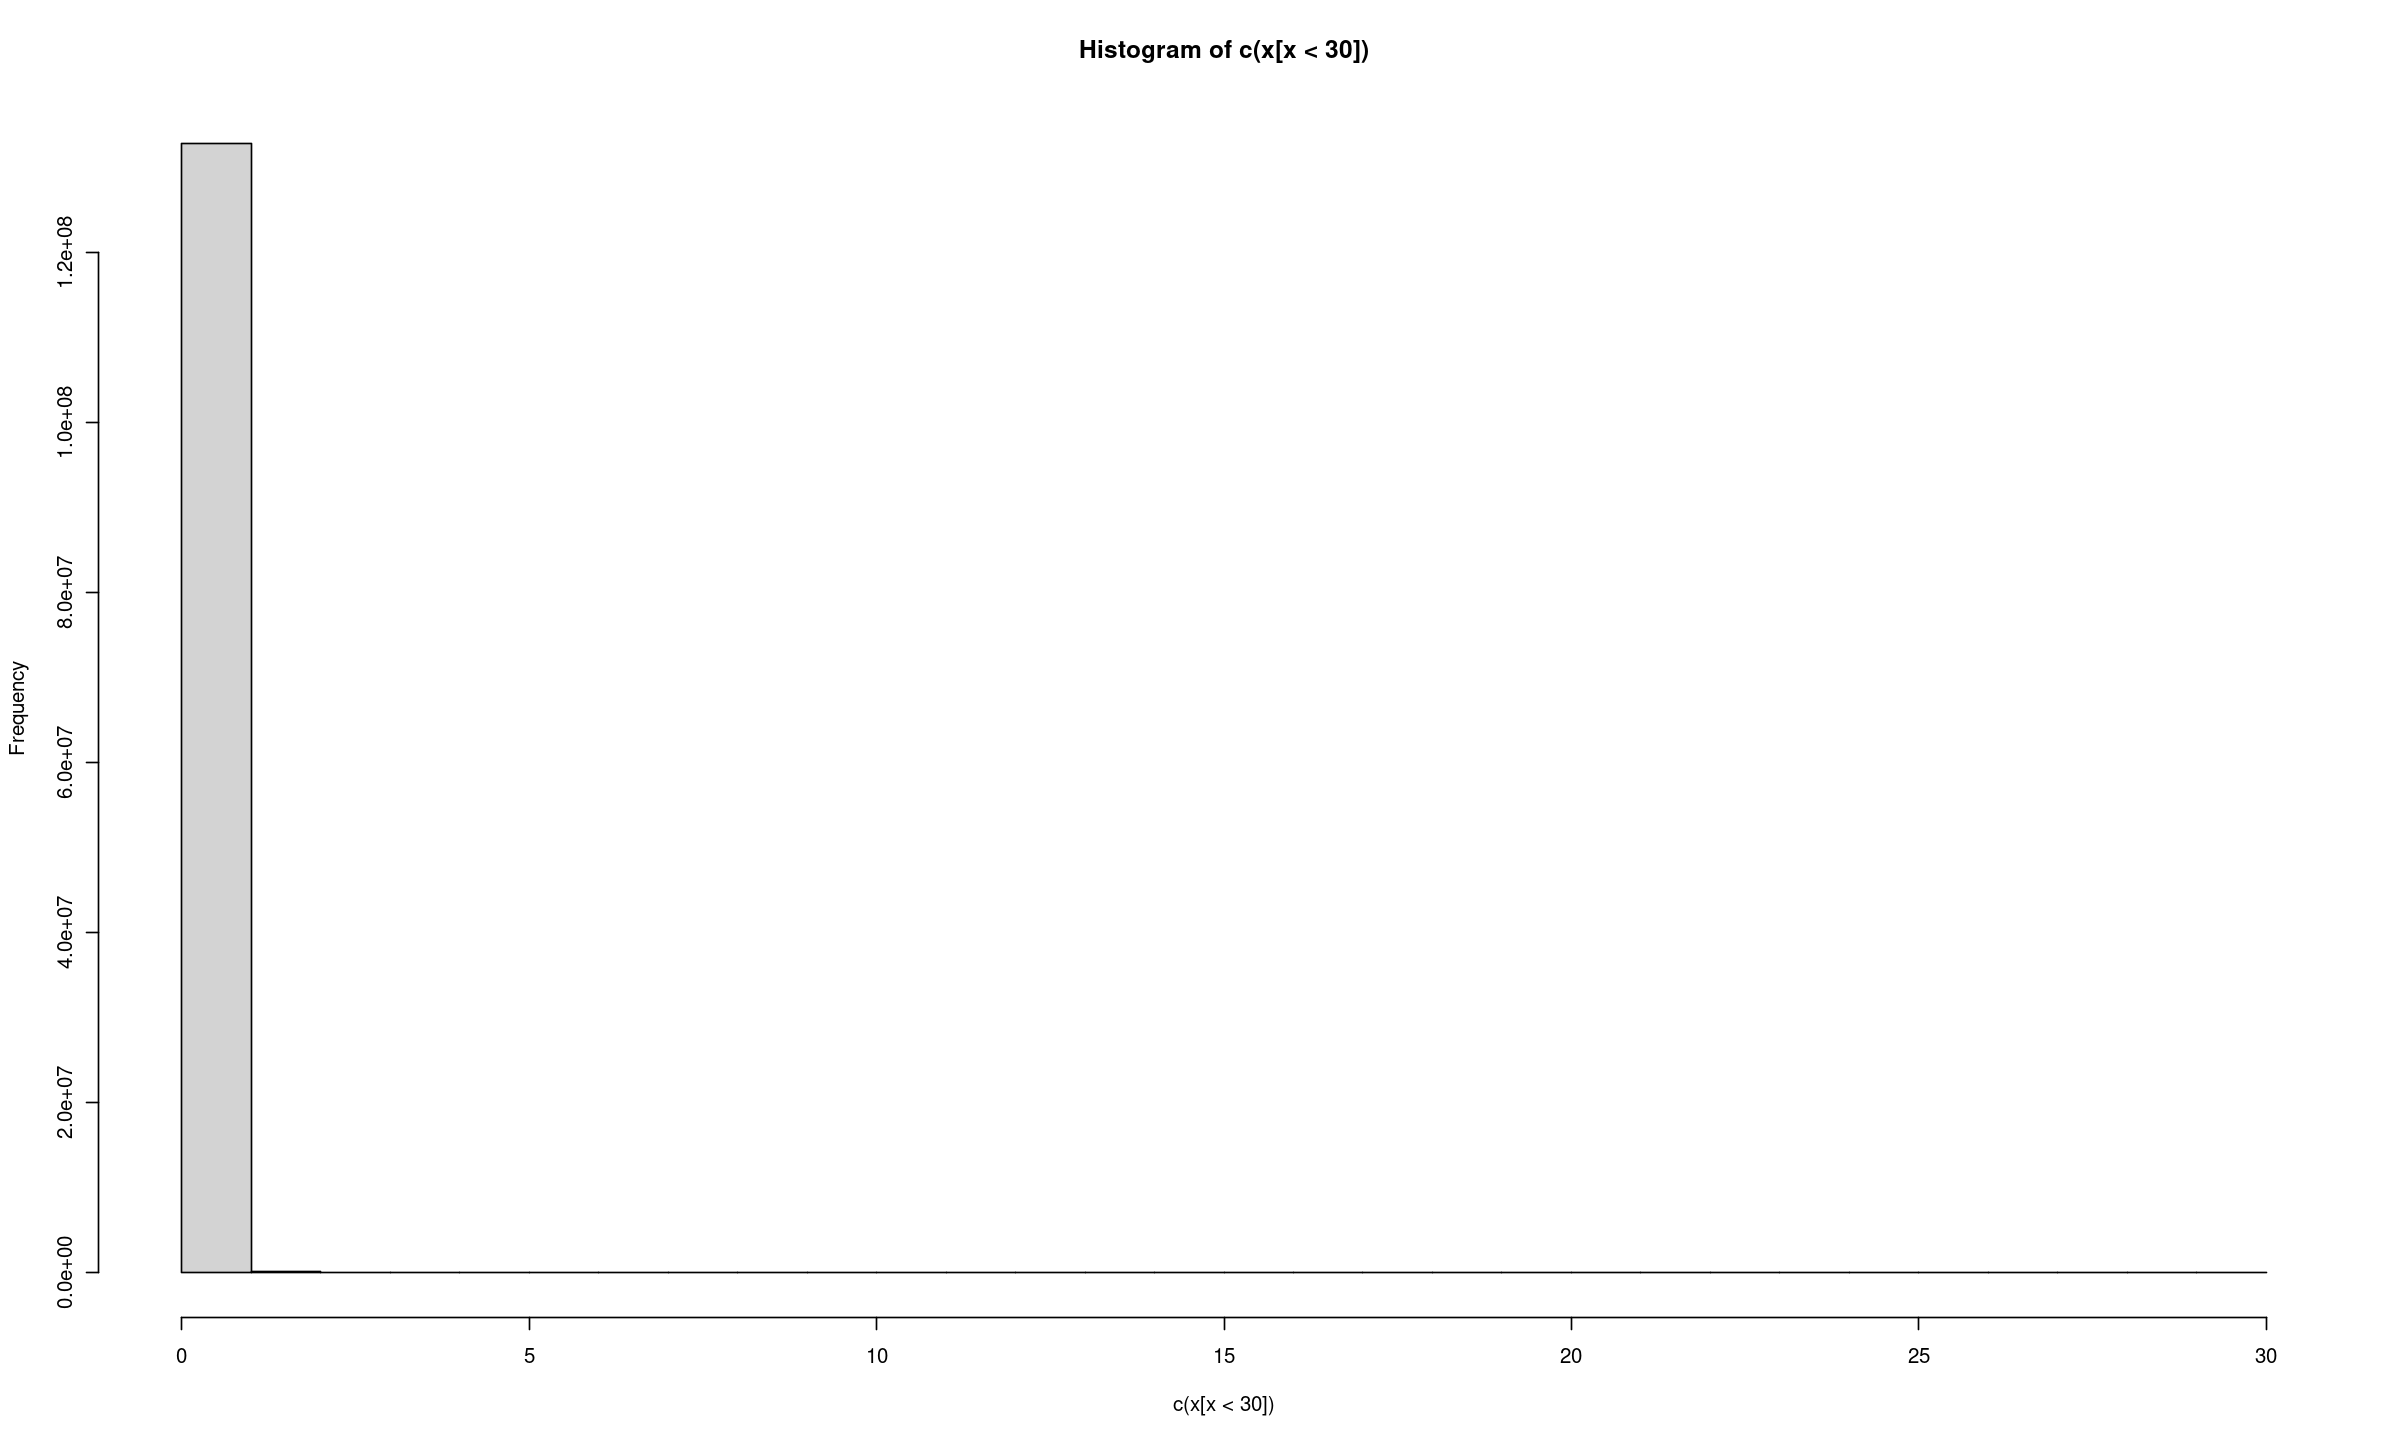

In [49]:
h <- hist(c(x[x<30]),breaks=seq(0,30,1))


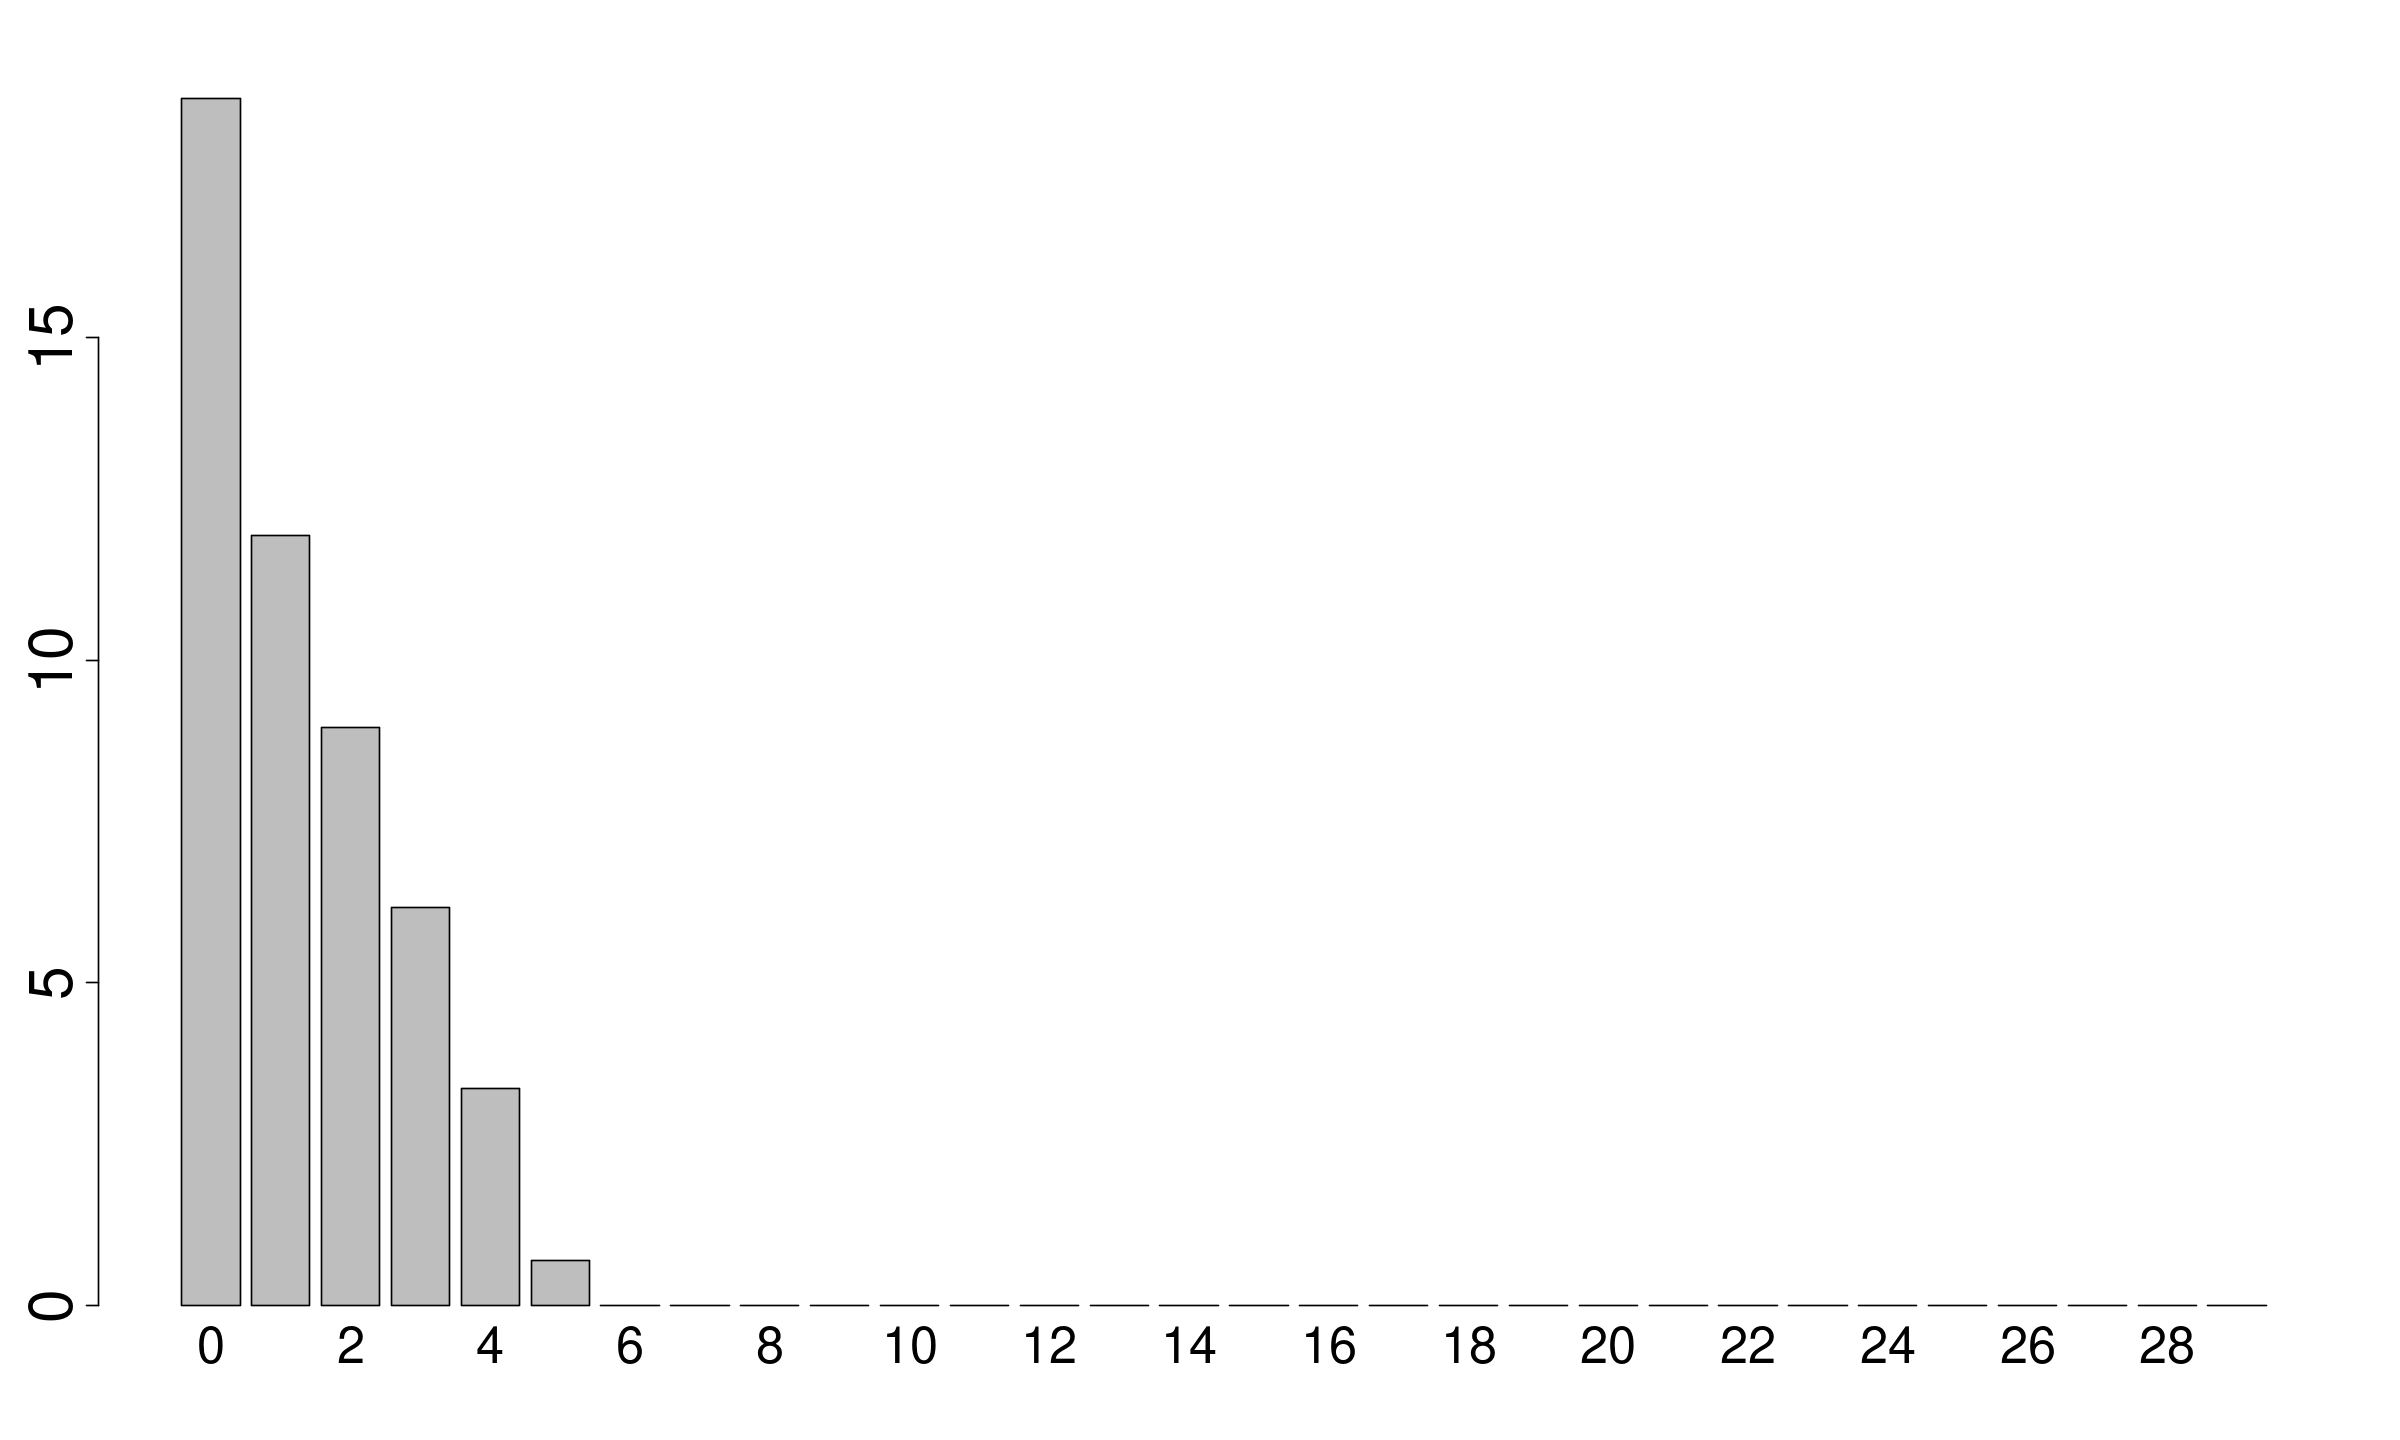

In [50]:
barplot(log(h$counts+1), names.arg = h$breaks[1:30],cex.axis=3,cex.names=2.5)


Call:
lm(formula = vr ~ mn)

Coefficients:
(Intercept)           mn  
  -0.001178     1.096276  


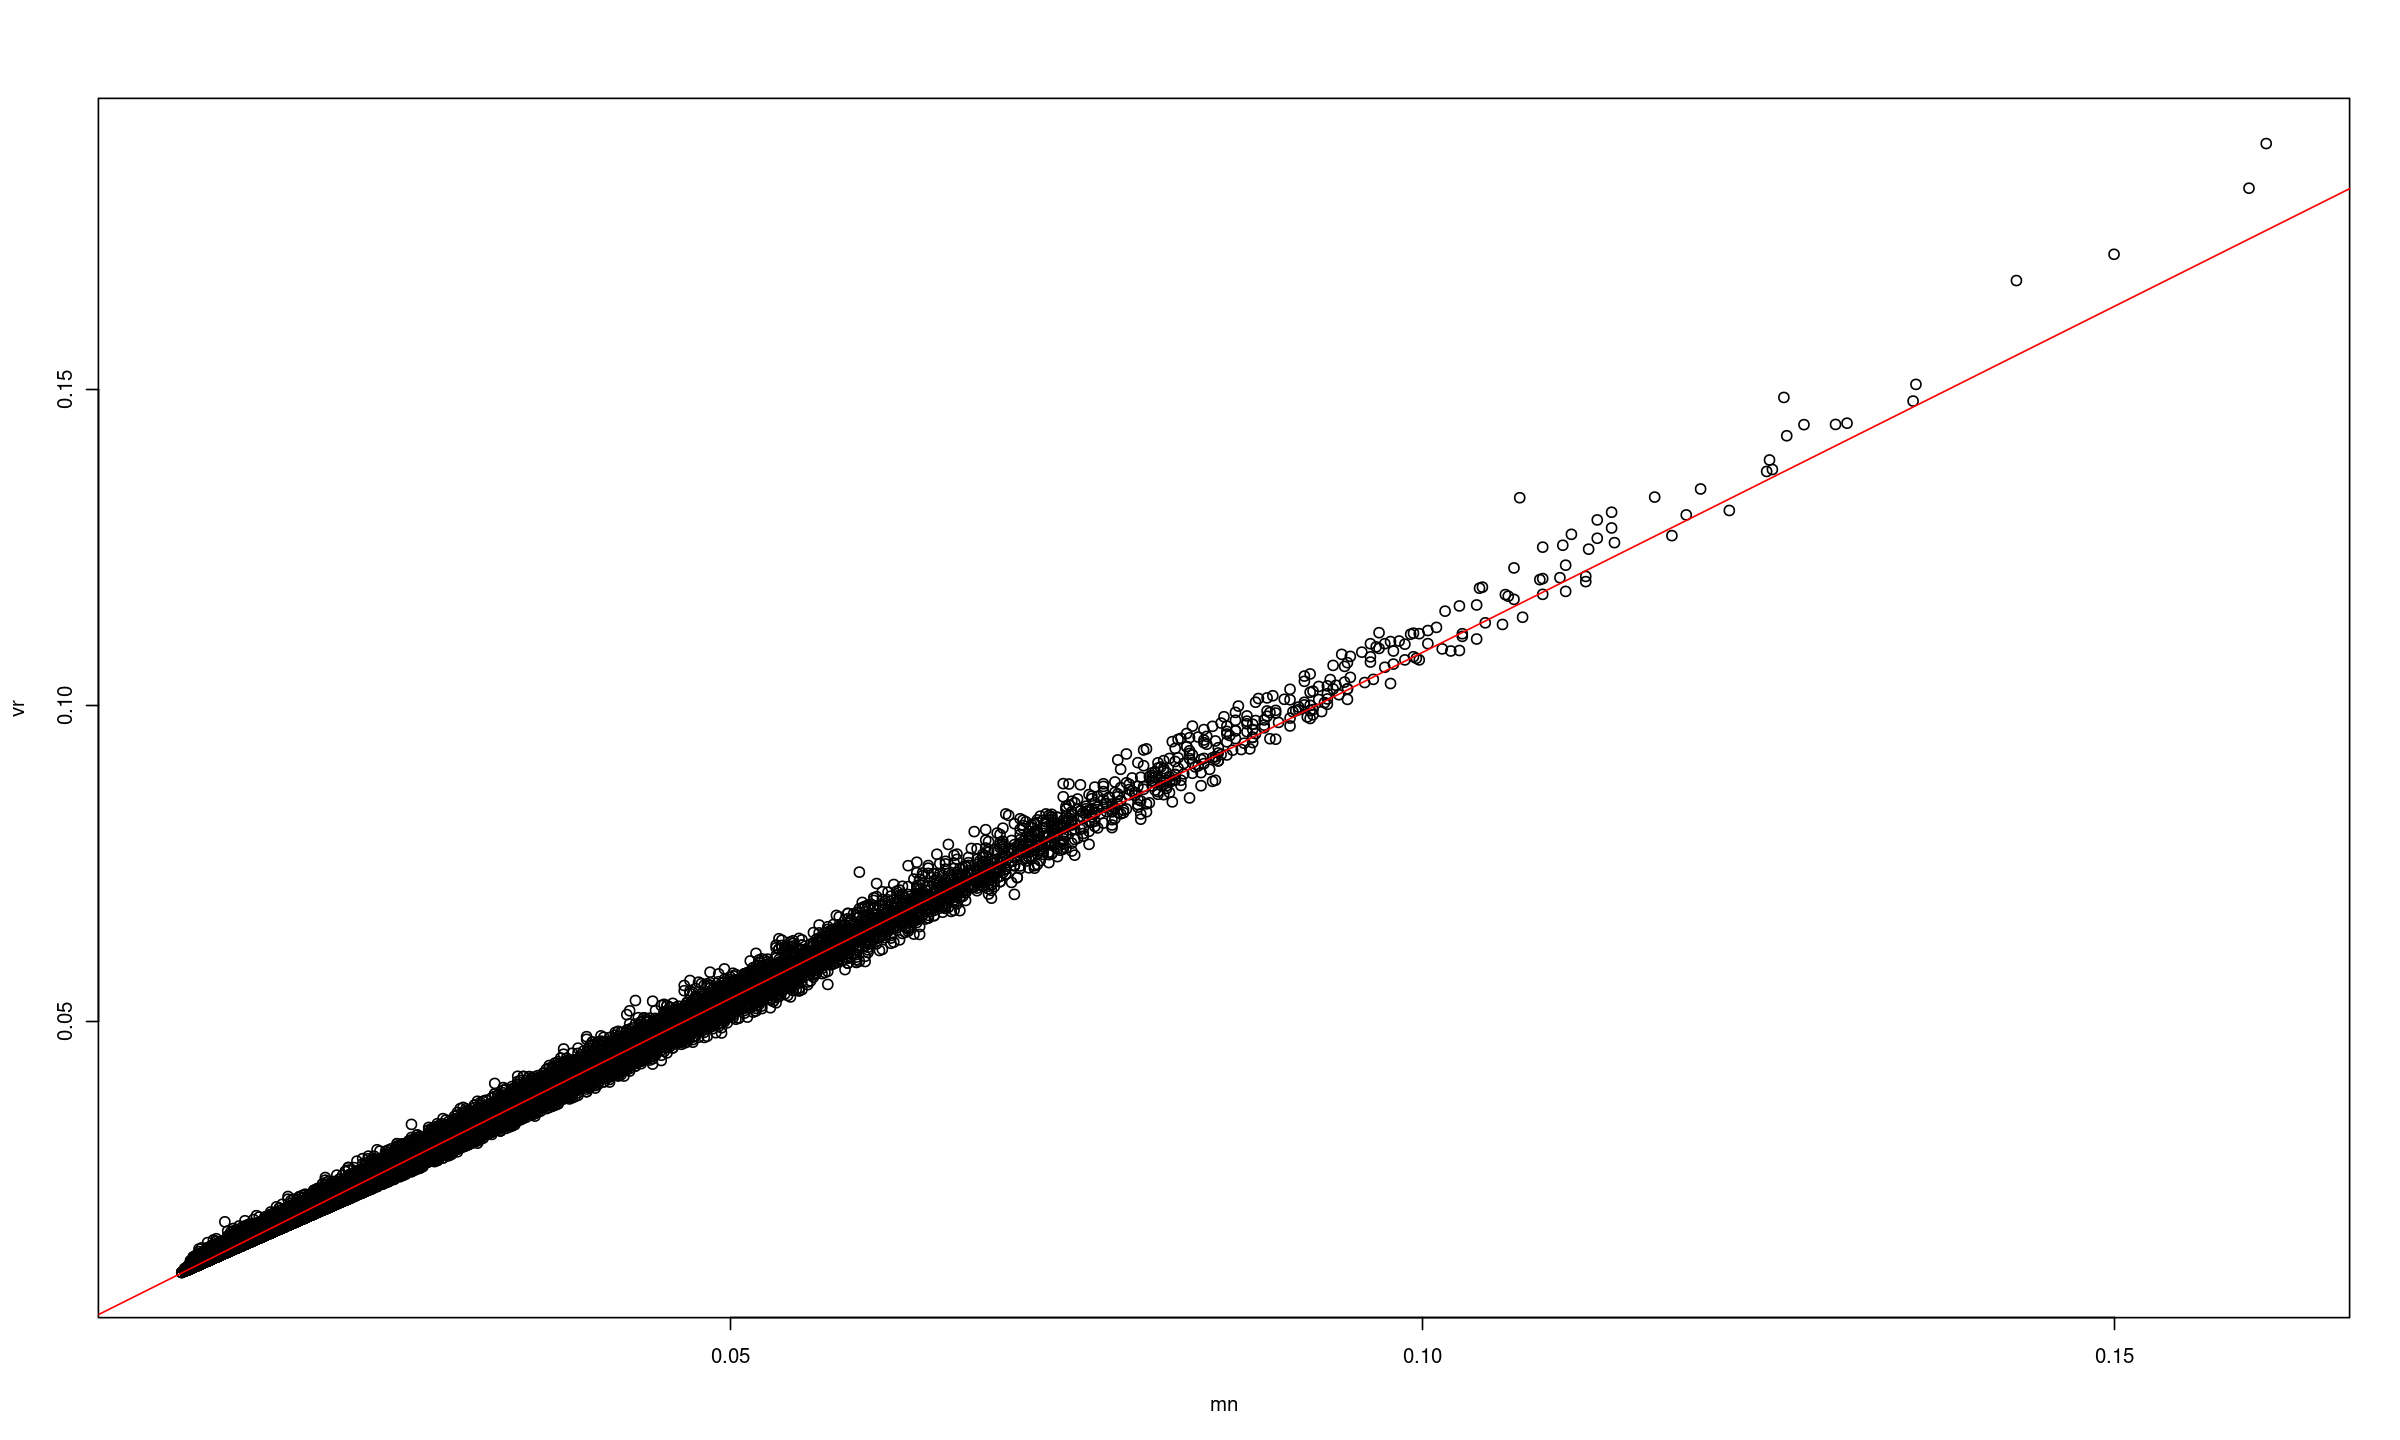

In [51]:
# Mean-variance relationship
mn <- apply(x, 2, mean)
vr <- apply(x, 2, var) 
plot(mn,vr)
reg<-lm(vr ~ mn)
abline(reg,col="red")
reg

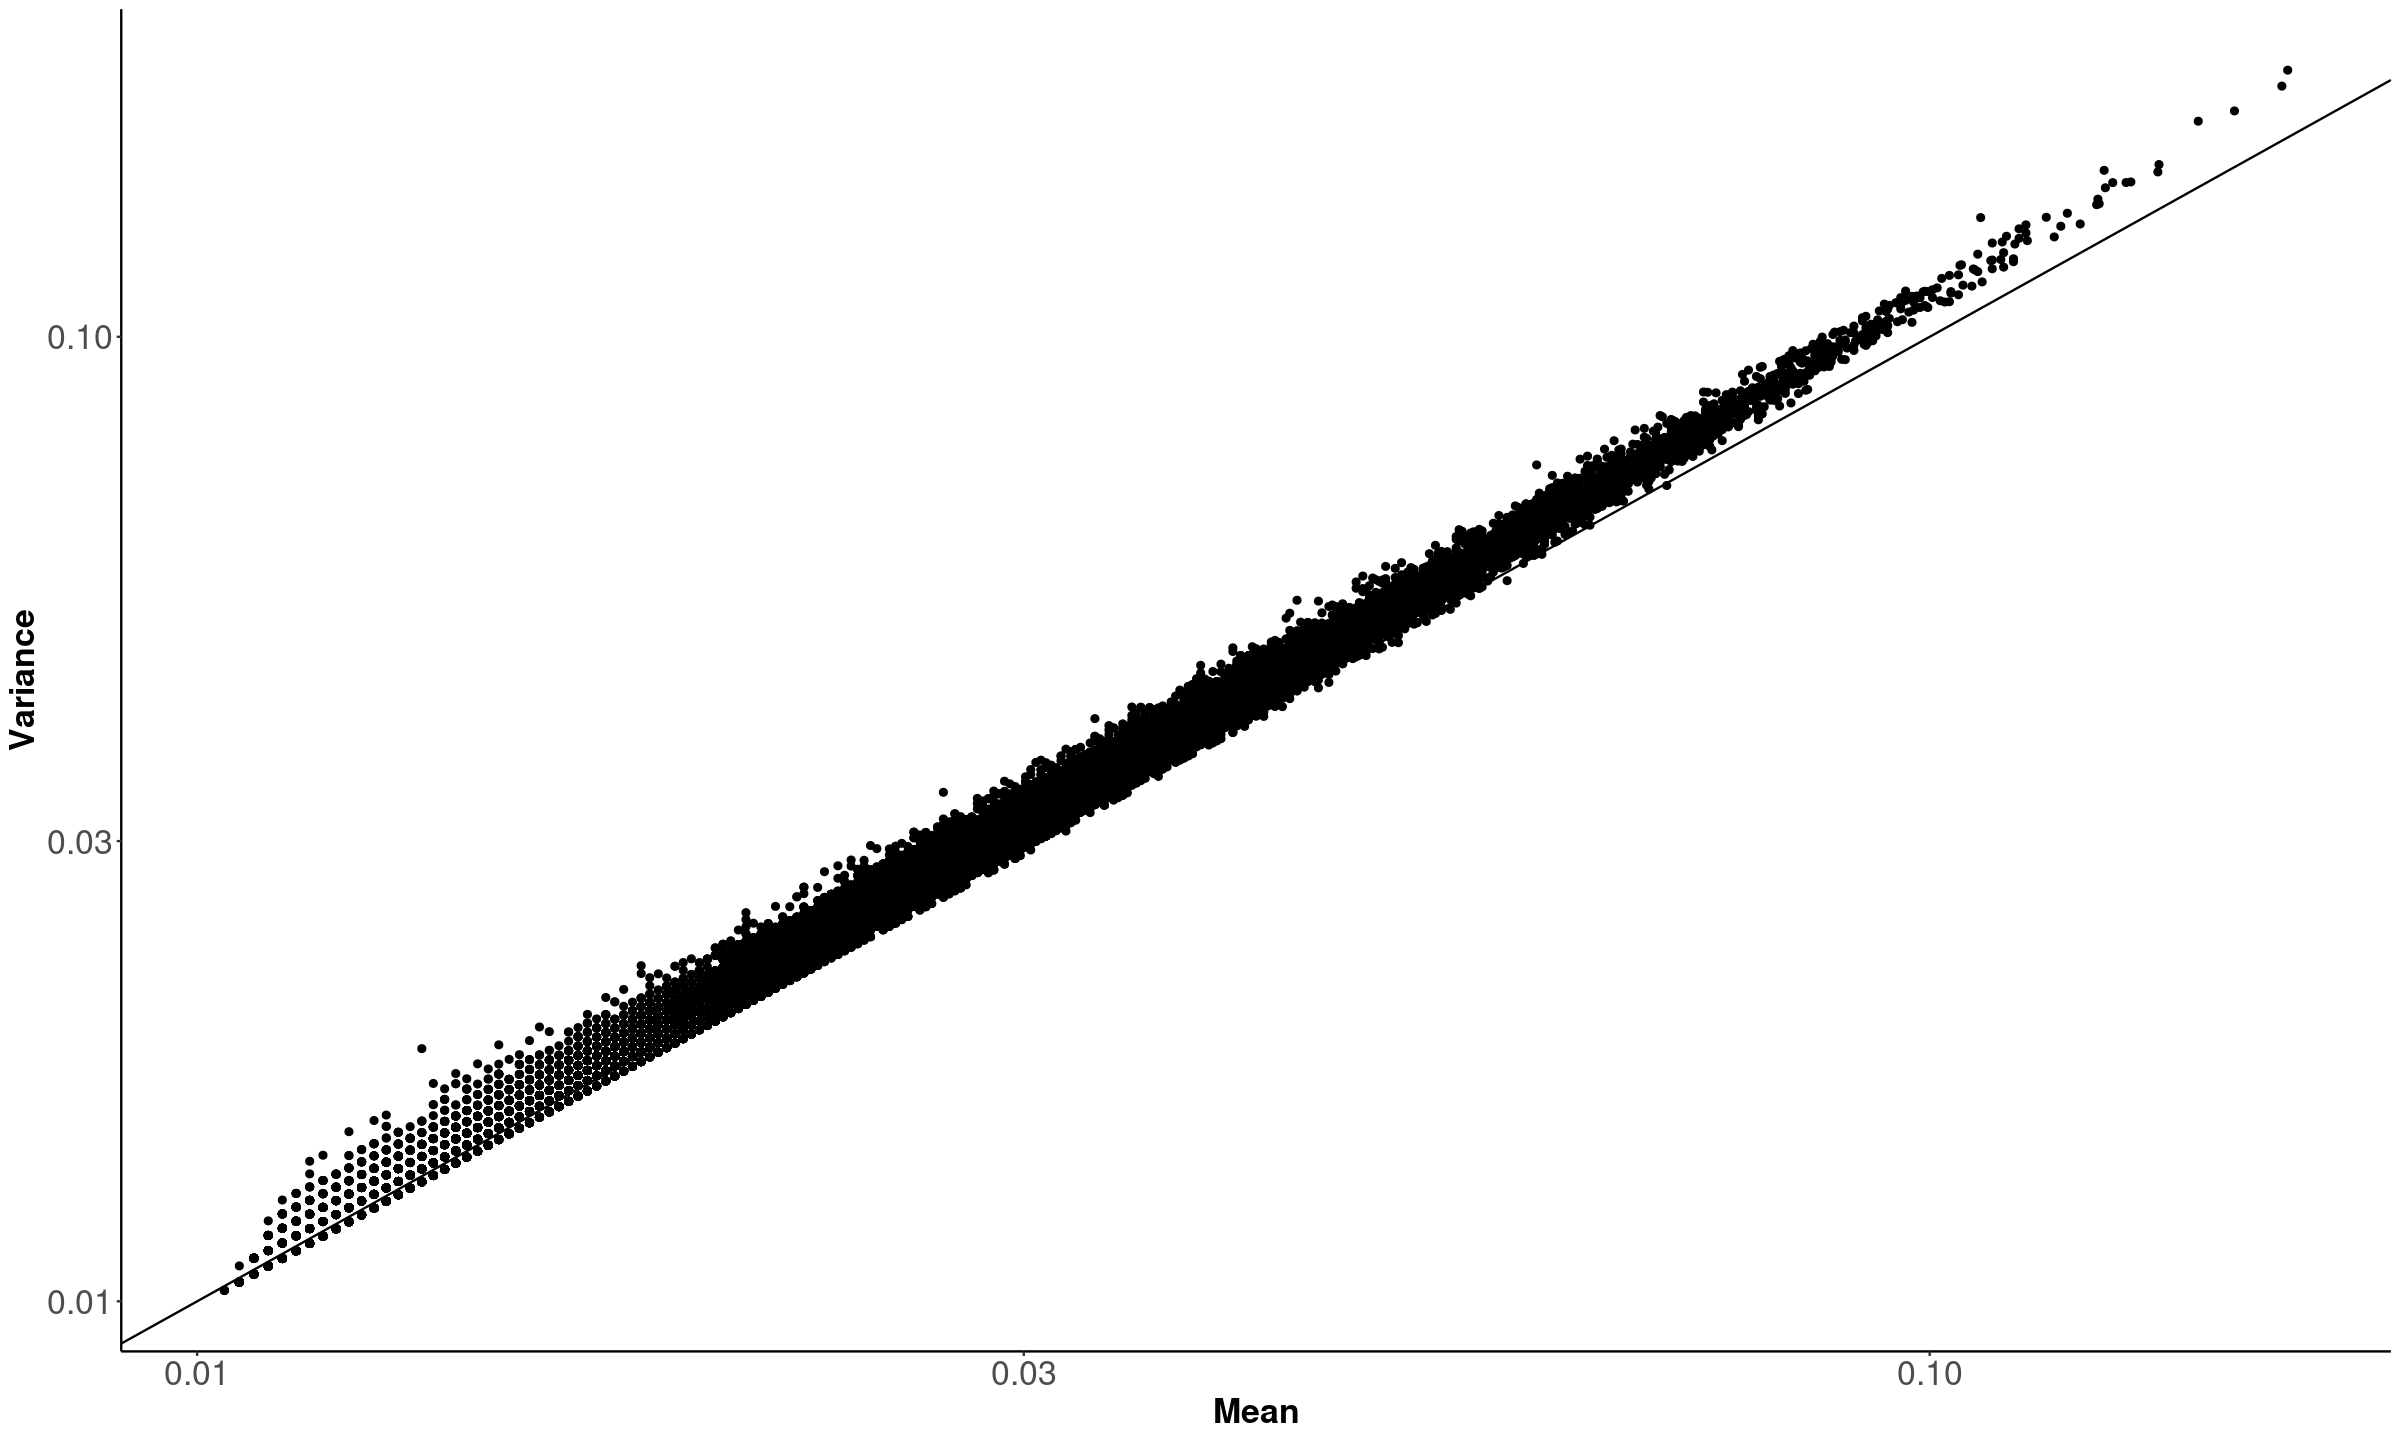

In [52]:
ggplot(data.frame(Mean = mn,Variance = vr),aes(Mean, Variance)) + geom_point() +geom_abline(
  mapping = NULL,
  data = NULL,
  intercept = 0, 
  slope = 1,
  na.rm = FALSE,
  show.legend = NA
) + scale_x_log10() + scale_y_log10() +theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"),axis.text=element_text(size=20),axis.title=element_text(size=20,face="bold"))


  #scale_y_continuous(trans='log10')

# Main routine 
Running for multiple number of clusters, and then choosing the best model using AIC

In [53]:
#### =========================== Main function =============================

old <- Sys.time()
print(old)  # start time

EPS  <- 0.000001 # small value, gloablly defined, for dealing with underflow
delta <- 0.0001 # Used in EM convergence stopping criteria

x_sel <- 1:dim(x)[2] # Index of selected peaks, all of them initially 

models <- list(2,4,5,6,7,8,9,10)#, 10, 15, 20) #  Possible number of clusters

max_z_idx1 <- matrix(1,nrow=N,ncol=length(models)) # To store labels for all models 
max_z_idx <- matrix(1,nrow=N,1) # cluster labels, global variable

AC <- matrix(1,nrow=length(models),1) # To store AIC values for each model


for (i in 1:length(models)){
    
    K <- models[[i]] # current number of clusters
    lambda_i_k <- matrix(0,nrow = K,ncol = length(x_sel)) # parameters for current model
    
    # ======== Calculate variable selection (only in case of K==2)  ======
    if(i==1){
        tmp1 <- colSums(x)/N 
        lambda_i_0 <- matrix(1,nrow=1,ncol = length(x_sel))
        lambda_i_0[1,] <- tmp1[1:length(x_sel)] 
        # Quick EM
        Iter_QuickEM <- 10
        converged <- 0
        resEM <- MaximizationStep_optim() # M-step, First iter
        objective_tmp <- resEM[[3]]
        lambda_i_k[1:K,1:length(x_sel)] <- resEM[[2]]
        iter <- 0
        while(converged == 0){
             z <- compute_z() # E-setp 
             for (l in 1:N){ max_z_idx[l] <- which.max(z[l,]) } # CEM
             resEM <- MaximizationStep_optim() 
             lambda_i_k[1:K,1:length(x_sel)] <- resEM[[2]]
             tmp <- abs(resEM[[3]] - objective_tmp)
             if(tmp <= delta*abs(objective_tmp) | iter>=Iter_QuickEM) { 
                converged <- 1
                objective_tmp <- resEM[[3]]
             }
             iter <- iter + 1
             objective_tmp <- resEM[[3]]
        }# while
        
        # Calculation of gain in log LK for every peak
        Y <- calc_Y_i() 
        x_sel <- order(Y,decreasing = TRUE)[Y>quantile(Y, probs = c(0.1,0.3,0.5,0.6,0.7,0.8,0.9))[4] ]  # Peak selection based on percentiles
        lambda_i_k <-  lambda_i_k[,x_sel]          
    }
 
         
         
    # Random Restarts
    num_restarts <- 10
    num_iter_restarts <- 5
    max_z_idx_tmp <- matrix(1,nrow=N,ncol=num_restarts)   
    idx <- 1
    for (m in 1:num_restarts){ # small EM to initialize
        max_z_idx_tmp[,m] <- sample(1:K,N,replace=TRUE) 
        max_z_idx <- max_z_idx_tmp[,m]
        for (k in 1:K){
            lambda_i_k[k,] <- (colSums(x[max_z_idx==k,x_sel])+1)/(sum(max_z_idx==k)+1)     # ML estimator
        } 
        # run for num_iter_restarts iterations       
        resEM <- MaximizationStep_optim() # M-step, First iter
        objective_tmp <- resEM[[3]]
        lambda_i_k[1:K,1:length(x_sel)] <- resEM[[2]]
        if(m==1){
            objective_old <- objective_tmp
            lambda_i_k_old <- lambda_i_k
        }
        iter <- 0
        while(iter<=num_iter_restarts){
          z <- compute_z() # E-setp 
          for (l in 1:N){ max_z_idx[l] <- which.max(z[l,]) }
          resEM <- MaximizationStep_optim() 
          lambda_i_k[1:K,1:length(x_sel)] <- resEM[[2]]
          objective_tmp <- resEM[[3]]
          iter <- iter + 1   
        }# while
                     
        if(objective_tmp < objective_old){
           objective_old <- objective_tmp
           lambda_i_k_old <- lambda_i_k
           idx <- m
        }
    }
    
    # Final initialization using random restarts
    max_z_idx <- max_z_idx_tmp[,idx]
    objective_tmp <- objective_old
    lambda_i_k   <- lambda_i_k_old
    
         
    # === Main EM ======================= 
    converged <- 0
    resEM <- MaximizationStep_optim() # M-step, First iter
    objective_tmp <- resEM[[3]]
    lambda_i_k[1:K,1:length(x_sel)] <- resEM[[2]]
    lambda_i_k_old <- lambda_i_k
    iter <- 0
    while(converged == 0){
         z <- compute_z() # E-setp 
         for (l in 1:N){
             max_z_idx[l] <- which.max(z[l,]) # CEM
         }
         resEM <- MaximizationStep_optim() # M-step
         lambda_i_k[1:K,1:length(x_sel)] <- resEM[[2]]
         lambda_i_k_old <- lambda_i_k
         tmp <- abs(resEM[[3]] - objective_tmp)
         if(tmp <= delta*abs(objective_tmp) | iter>=20) { 
            converged <- 1
            objective_tmp <- resEM[[3]]
         }
         iter <- iter + 1
         objective_tmp <- resEM[[3]]     
    }# while
 

 AC[i] <- -2.0*1.0*objective_tmp + 2*(length(x_sel)*K+K-1) 
 max_z_idx1[,i] <- max_z_idx   
 
print(objective_tmp)    
}# outer loop
 
new <- Sys.time() - old
print(new) # printing time


[1] "2023-01-19 09:04:30 GMT"
[1] -6261135
[1] -6133892
[1] -6065755
[1] -6001088
[1] -5937552
[1] -5870461
[1] -5866662
[1] -5864027
Time difference of 6.920446 hours


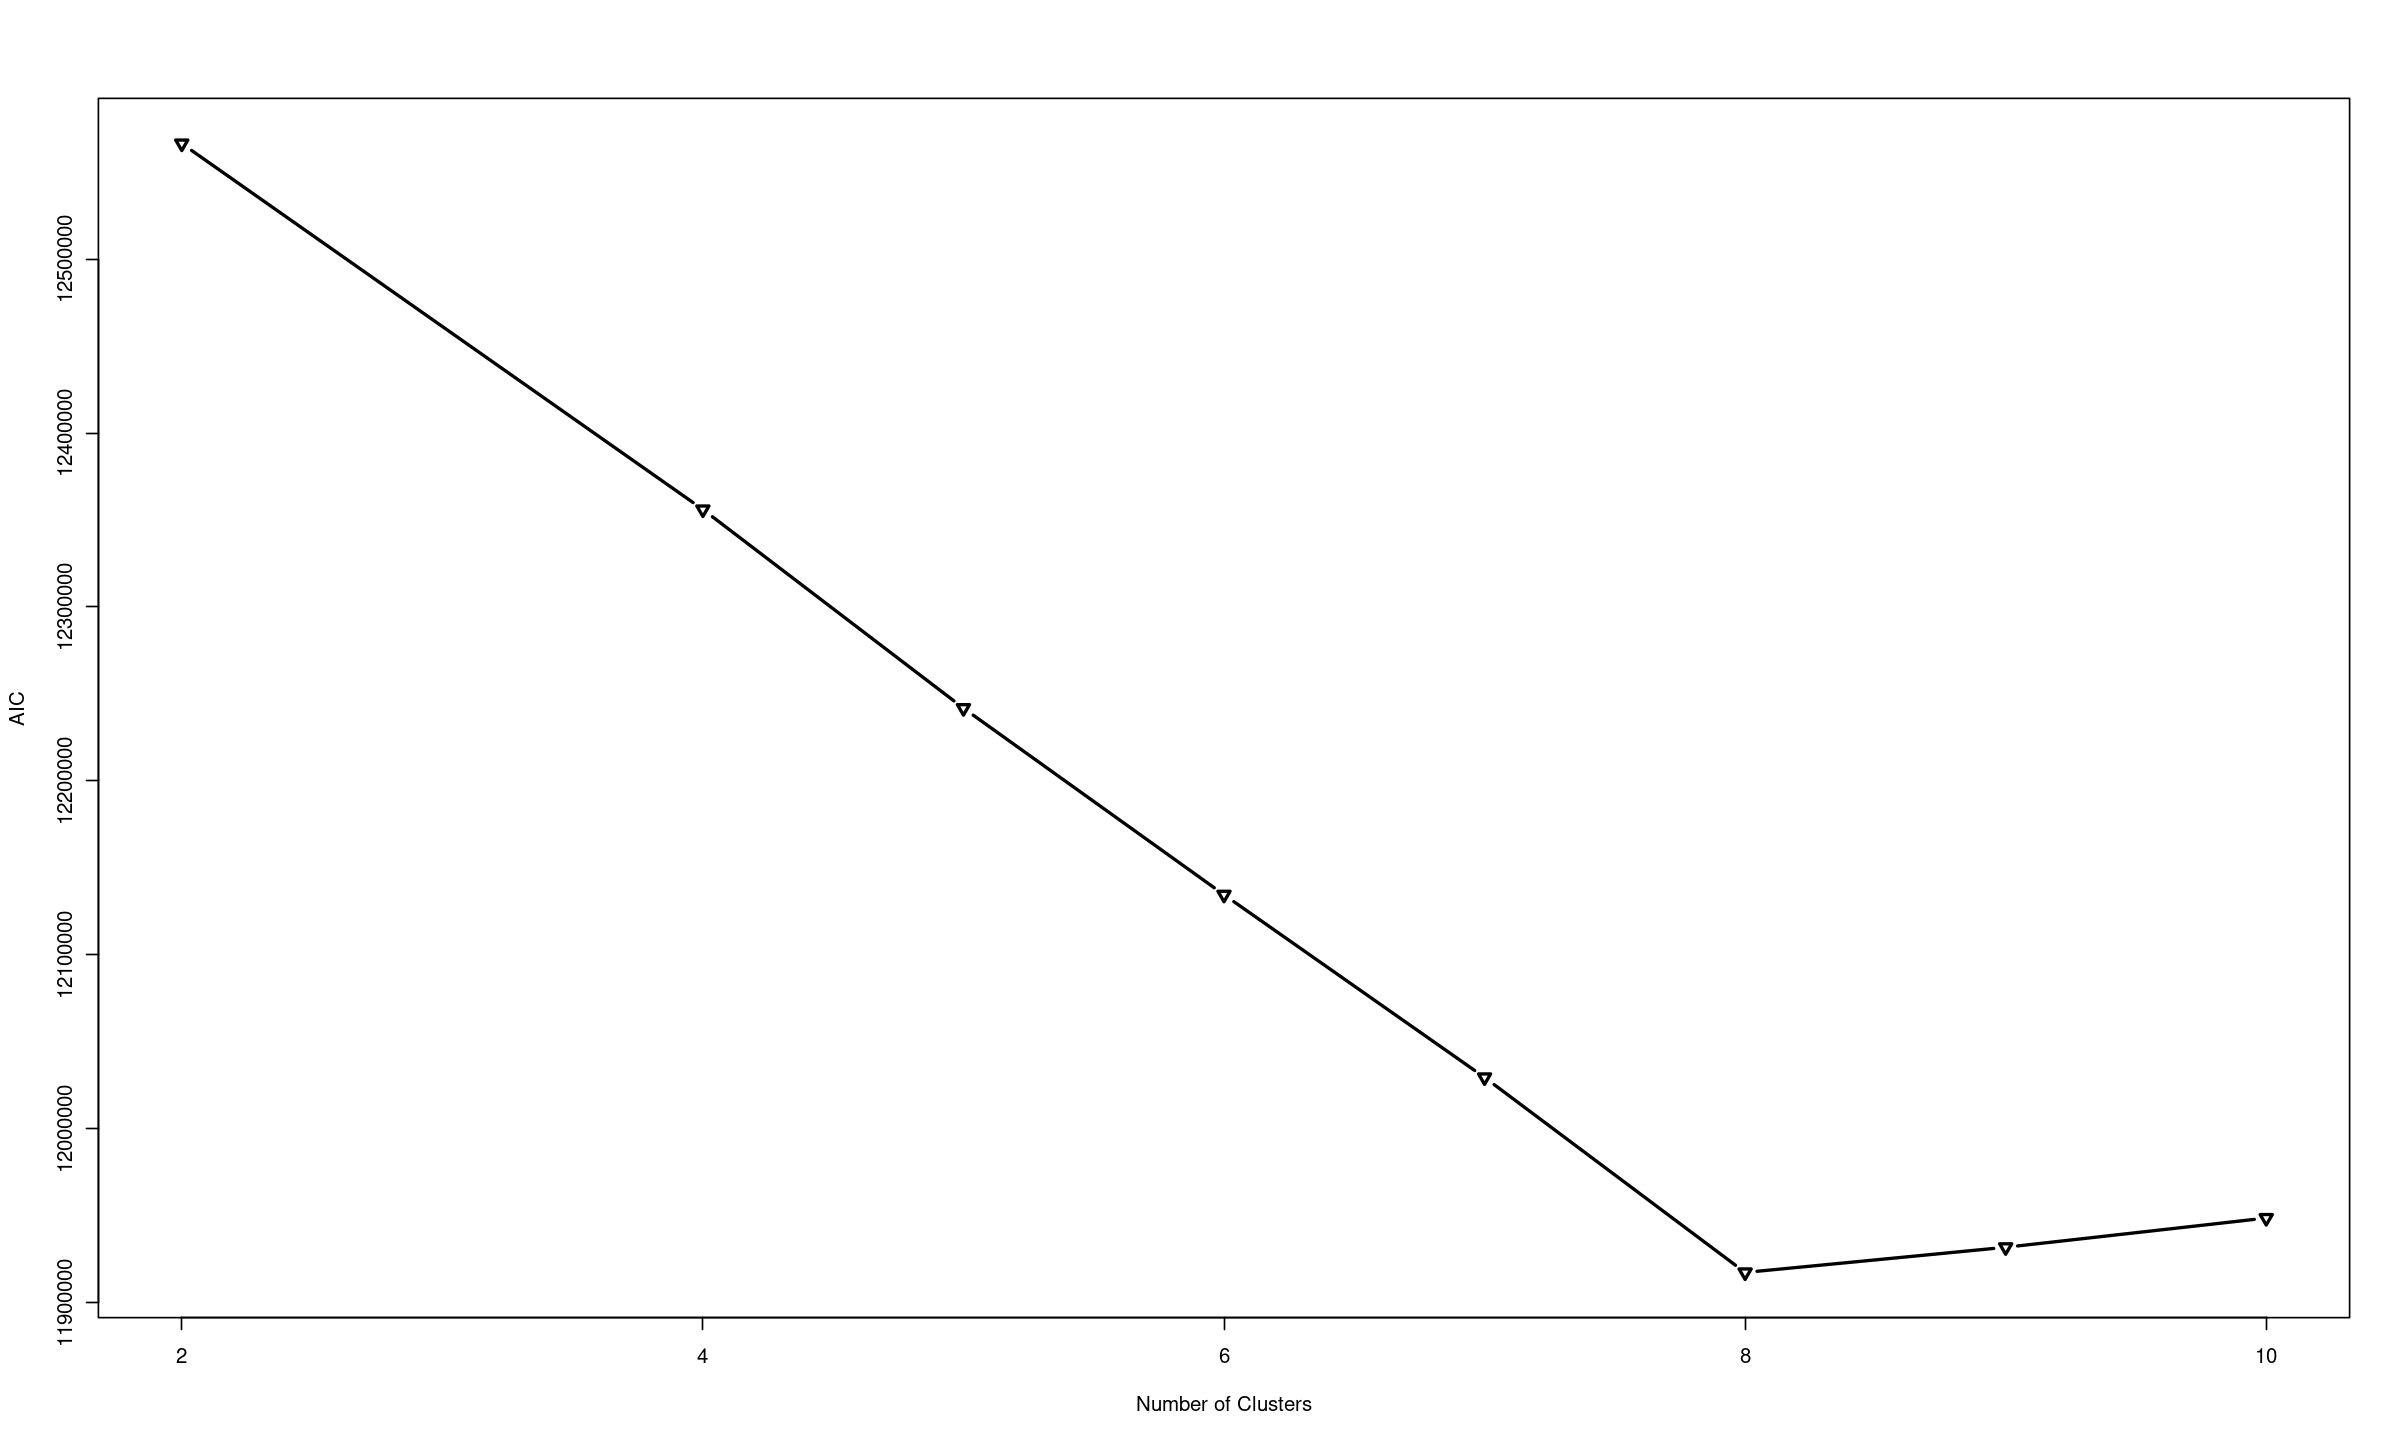

In [54]:
plot(models,1.0*AC, type="b", col="black", lwd=2, pch=25, xlab="Number of Clusters", ylab="AIC") #, main="Exponential decay"

In [55]:
# Selecting best model, writing clustering labels to file
best_idx <- which.min(AC)
#write.csv(max_z_idx1[,best_idx], './cluster_labels_final130123/Cluster_labels_current_Synthetic.csv') 
max_z_idx <- max_z_idx1[,best_idx] 
#write.csv(max_z_idx1, './cluster_labels_final130123/Cluster_labels_All_AIC_Synthetic.csv')  

In [56]:
table(max_z_idx)

max_z_idx
  1   2   3   4   5   6   7   8 
605 606 631 584 628 609 556 603 

# Signac Clustering 

In [57]:
library(Seurat)
library(Signac)
# https://satijalab.org/signac/articles/pbmc_vignette.html # Signac vignette for reference

In [58]:
res_seurat = 0.25

In [59]:
#colnames(x) = c(1:dim(x)[2]) # Just added cell names in order to satisfy requirement of Seurat
#rownames(x) = c(1:dim(x)[1]) # Just added cell names in order to satisfy requirement of Seurat

In [60]:
# Script for creating LSI based clusters (Signac)
x_Seurat <- CreateSeuratObject(
  counts = t(x), # before this x is cellsXpeaks, so transposing it so this script will cluster cells
  #counts = counts,
    #assay = "peaks",
  #meta.data = metadata
)

x_Seurat <- RunTFIDF(x_Seurat)
x_Seurat <- FindTopFeatures(x_Seurat, min.cutoff = 'q5') #  using fewer features, like q75 (works better eith q0 or q25), completely ruins seurat clustering
x_Seurat <- RunSVD(x_Seurat)

Performing TF-IDF normalization

Running SVD

Scaling cell embeddings



In [61]:
#x_Seurat

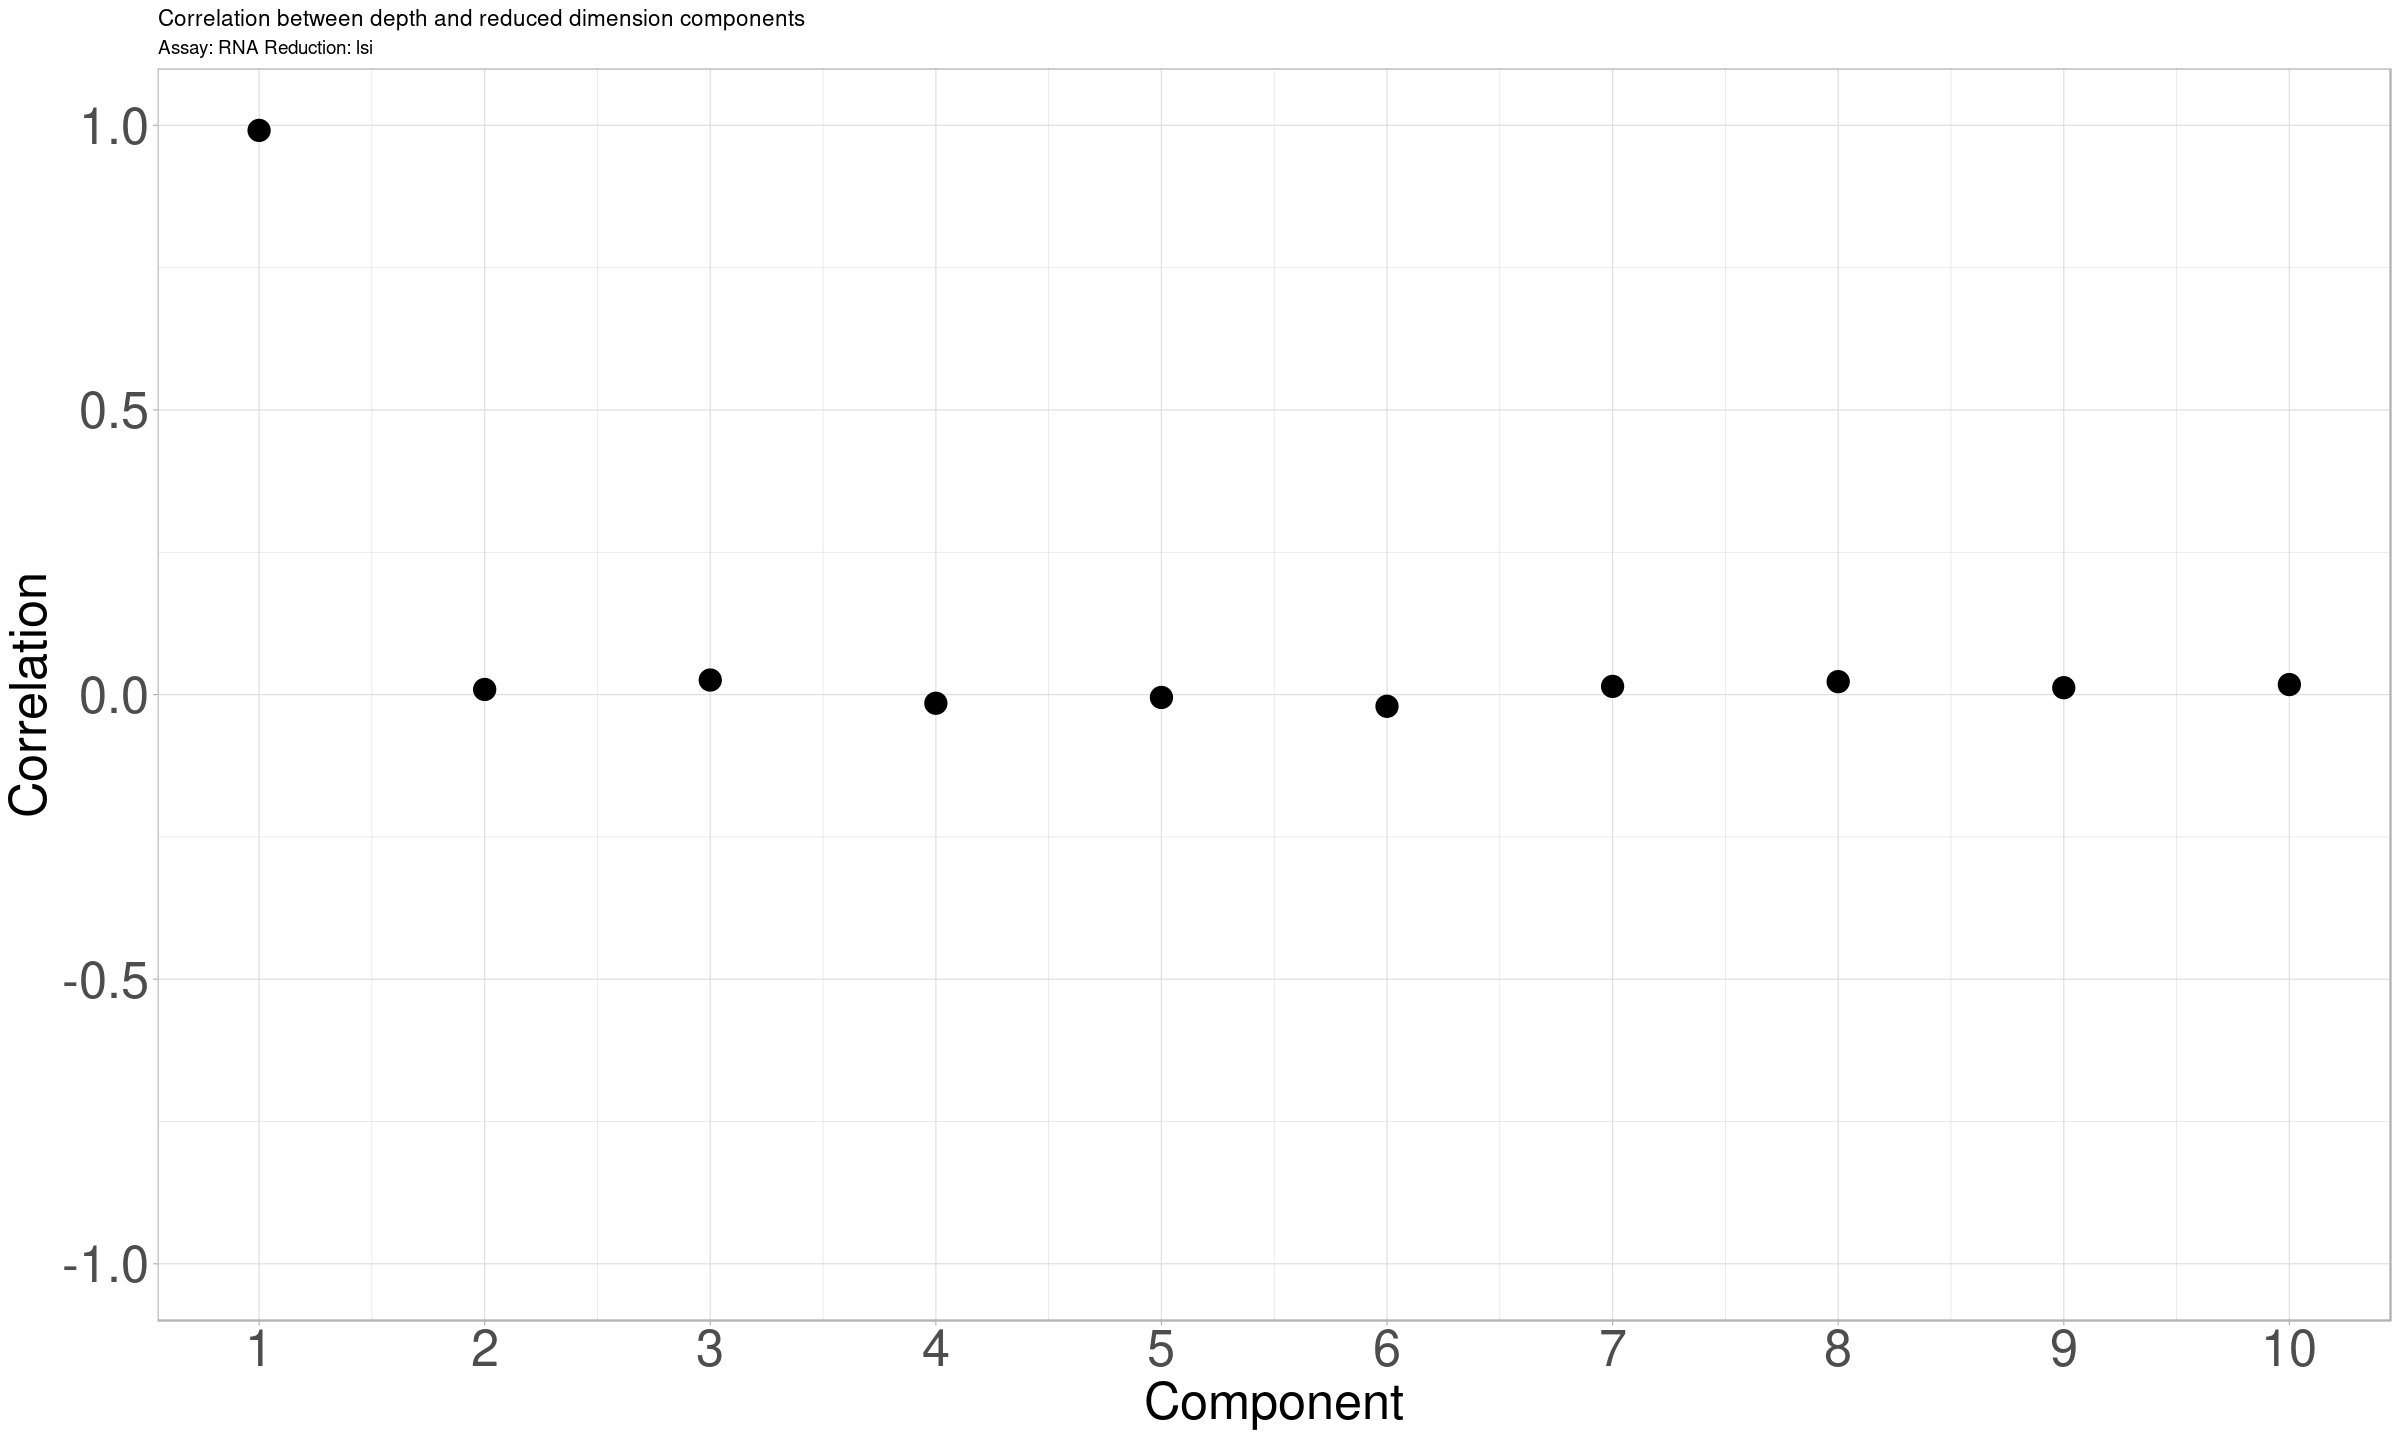

In [62]:
dc <- DepthCor(x_Seurat) # returns a ggplot object
dc + theme(axis.text=element_text(size=30),
        axis.title=element_text(size=30)) + geom_point(size=5.5)

In [63]:
x_Seurat <- RunUMAP(object = x_Seurat, reduction = 'lsi', dims = 1:30)
x_Seurat <- FindNeighbors(object = x_Seurat, reduction = 'lsi', dims = 1:30)
x_Seurat <- FindClusters(object = x_Seurat, verbose = FALSE, algorithm = 3,resolution = res_seurat)
#DimPlot(object = x_Seurat, label = TRUE) + NoLegend()

15:59:55 UMAP embedding parameters a = 0.9922 b = 1.112

15:59:55 Read 4822 rows and found 30 numeric columns

15:59:55 Using Annoy for neighbor search, n_neighbors = 30

15:59:55 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

15:59:56 Writing NN index file to temp file /tmp/4125270.1.parallel.q/RtmpFRnnDy/file3578475a2bb5

15:59:56 Searching Annoy index using 1 thread, search_k = 3000

15:59:57 Annoy recall = 100%

15:59:58 Commencing smooth kNN distance calibration using 1 thread

16:00:00 Initializing from normalized Laplacian + noise

16:00:00 Commencing optimization for 500 epochs, with 201430 positive edges

16:00:15 Optimization finished

Computing nearest neighbor graph

Computing SNN



In [64]:
# Signac clusters (with first LSI component)
# To start Seurat cluster from 1 instead of 0
clusters_Seurat_with <- as.factor(as.numeric(as.character(x_Seurat$seurat_clusters)) + 1)
length(clusters_Seurat_with)

[1] 4822

In [65]:
# Now running again for without first LSI reductioin
x_Seurat1 <- CreateSeuratObject(
  counts = t(x), # before this x is cellsXpeaks, so transposing it so this script will cluster cells
  #assay = "peaks",
  #meta.data = metadata
)

x_Seurat1 <- RunTFIDF(x_Seurat1)
x_Seurat1 <- FindTopFeatures(x_Seurat1, min.cutoff = 'q5')#q0
x_Seurat1 <- RunSVD(x_Seurat1)

Performing TF-IDF normalization

Running SVD

Scaling cell embeddings



In [66]:
# Without first LSI component
x_Seurat1 <- RunUMAP(object = x_Seurat1, reduction = 'lsi', dims = 2:30)
x_Seurat1 <- FindNeighbors(object = x_Seurat1, reduction = 'lsi', dims = 2:30)
x_Seurat1 <- FindClusters(object = x_Seurat1, verbose = FALSE, algorithm = 3,resolution = res_seurat)

16:00:29 UMAP embedding parameters a = 0.9922 b = 1.112

16:00:29 Read 4822 rows and found 29 numeric columns

16:00:29 Using Annoy for neighbor search, n_neighbors = 30

16:00:29 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

16:00:30 Writing NN index file to temp file /tmp/4125270.1.parallel.q/RtmpFRnnDy/file35785da06c59

16:00:30 Searching Annoy index using 1 thread, search_k = 3000

16:00:31 Annoy recall = 100%

16:00:32 Commencing smooth kNN distance calibration using 1 thread

16:00:33 Initializing from normalized Laplacian + noise

16:00:34 Commencing optimization for 500 epochs, with 193546 positive edges

16:00:48 Optimization finished

Computing nearest neighbor graph

Computing SNN



In [67]:
# Signac clusters (without first LSI component)
clusters_Seurat_without = x_Seurat1@active.ident
clusters_Seurat_without <- as.factor(as.numeric(as.character(x_Seurat1$seurat_clusters)) + 1)
length(clusters_Seurat_without)

[1] 4822

# Combined plotting/visualization

In [85]:
clusters_SB <- max_z_idx
# Path to cell meta data file (true cluster labels)
clusters_TrueLabels <- as.data.frame(read.csv('./Data/Synthetic_new/Data1/5000EightClusterScaledPoissionLabs.csv', header = FALSE)) 
rownames(clusters_TrueLabels) <- c(1:dim(clusters_TrueLabels)[1])
clusters_TrueLabels <- clusters_TrueLabels[rownames(clusters_TrueLabels) %in% rownames(x),]

tsne_12 <- as.data.frame(x_Seurat@reductions$umap@cell.embeddings[])

# sequencing depth 
dp <- colSums(t(x),dims=1)/max(colSums(t(x),dims=1)) # no. of 1s normalized 


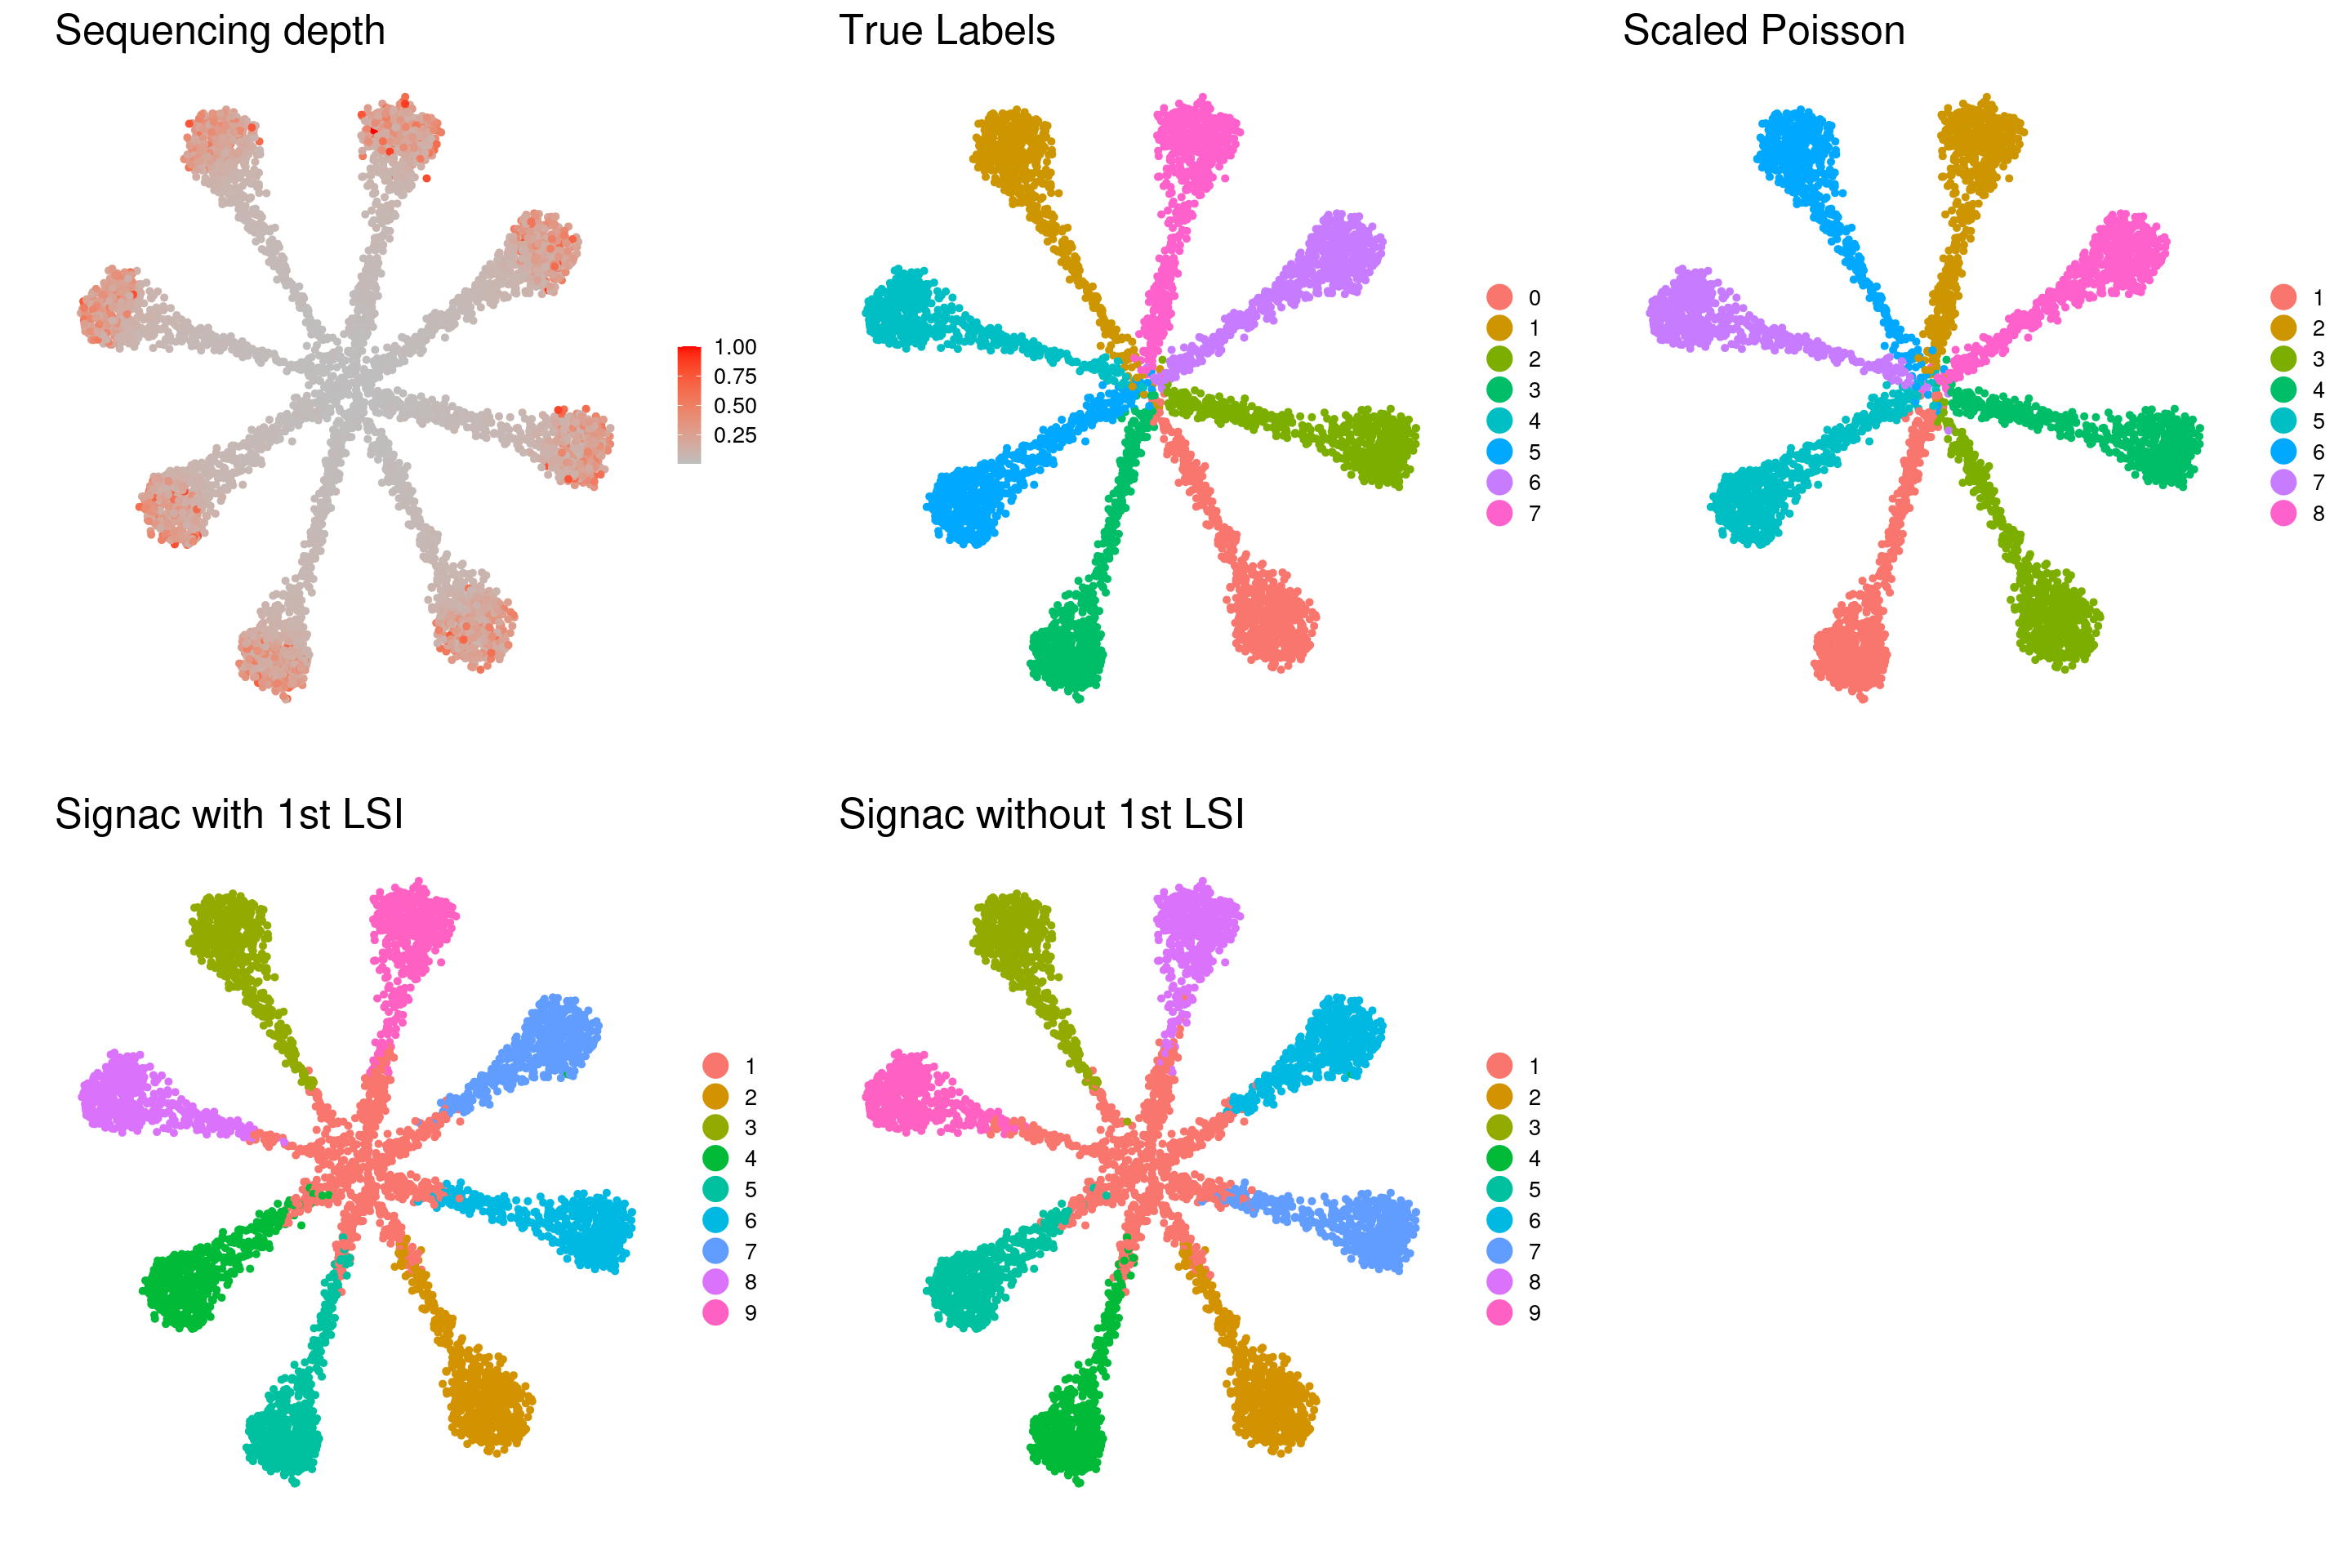

In [86]:
# ============= tsne  ==========================

options(repr.plot.width=24, repr.plot.height=16)

p1 <- ggplot(tsne_12, aes(x=tsne_12[,1], y=tsne_12[,2], color=dp)) +
     geom_point(size=1.75) +
scale_colour_gradient(
  low = "grey",
  high = "red",
  space = "Lab",
  na.value = "grey50",
  guide = "colourbar",
  aesthetics = "colour"
)+
     #guides(colour = guide_legend(override.aes = list(size=2.5))) +
     xlab("") + ylab("") +
     ggtitle("Sequencing depth") +
     theme_classic(base_size=20) +
     theme(strip.background = element_blank(),
           strip.text.x     = element_blank(),
           axis.text.x      = element_blank(),
           axis.text.y      = element_blank(),
           axis.ticks       = element_blank(),
           axis.line        = element_blank(),
           panel.border     = element_blank(),
           plot.title = element_text(size=30)) + 
labs(colour = NULL)#+
#guides(colour = guide_legend(override.aes = list(size=8)))

 
p2 <- ggplot(tsne_12, aes(x=tsne_12[,1], y=tsne_12[,2], color=as.factor(clusters_TrueLabels),text=as.factor(clusters_TrueLabels))) +
     geom_point(size=1.75) +
     guides(colour = guide_legend(override.aes = list(size=2.5))) +
     xlab("") + ylab("") +
     ggtitle("True Labels") +
     theme_classic(base_size=20) +
     theme(strip.background = element_blank(),
           strip.text.x     = element_blank(),
           axis.text.x      = element_blank(),
           axis.text.y      = element_blank(),
           axis.ticks       = element_blank(),
           axis.line        = element_blank(),
           plot.title = element_text(size=30)) + 
labs(colour = NULL)+
guides(colour = guide_legend(override.aes = list(size=8)))



p3 <- ggplot(tsne_12, aes(x=tsne_12[,1], y=tsne_12[,2], color=as.factor(clusters_SB),text=as.factor(clusters_SB))) +
     geom_point(size=1.75) +
     guides(colour = guide_legend(override.aes = list(size=2.5))) +
     xlab("") + ylab("") +
     ggtitle("Scaled Poisson") +
     theme_classic(base_size=20) +
     theme(strip.background = element_blank(),
           strip.text.x     = element_blank(),
           axis.text.x      = element_blank(),
           axis.text.y      = element_blank(),
           axis.ticks       = element_blank(),
           axis.line        = element_blank(),
          plot.title = element_text(size=30)) + 
labs(colour = NULL)+
guides(colour = guide_legend(override.aes = list(size=8)))

#clusters_FlexMix




 p4 <- ggplot(tsne_12, aes(x=tsne_12[,1], y=tsne_12[,2], color=as.factor(clusters_Seurat_with),text=as.factor(clusters_Seurat_with))) +
     geom_point(size=1.75) +
     guides(colour = guide_legend(override.aes = list(size=2.5))) +
     xlab("") + ylab("") +
     ggtitle("Signac with 1st LSI") +
     theme_classic(base_size=20) +
     theme(strip.background = element_blank(),
           strip.text.x     = element_blank(),
           axis.text.x      = element_blank(),
           axis.text.y      = element_blank(),
           axis.ticks       = element_blank(),
           axis.line        = element_blank(),
           plot.title = element_text(size=30)) + 
labs(colour = NULL)+
guides(colour = guide_legend(override.aes = list(size=8)))



 p5 <- ggplot(tsne_12, aes(x=tsne_12[,1], y=tsne_12[,2], color=as.factor(clusters_Seurat_without),text=as.factor(clusters_Seurat_without))) +
     geom_point(size=1.75) +
     guides(colour = guide_legend(override.aes = list(size=2.5))) +
     xlab("") + ylab("") +
     ggtitle("Signac without 1st LSI") +
     theme_classic(base_size=20) +
     theme(strip.background = element_blank(),
           strip.text.x     = element_blank(),
           axis.text.x      = element_blank(),
           axis.text.y      = element_blank(),
           axis.ticks       = element_blank(),
           axis.line        = element_blank(),
           plot.title = element_text(size=30)) + 
labs(colour = NULL)+
guides(colour = guide_legend(override.aes = list(size=8)))





#multiplot(p1,p2,p4,p5,p6,cols=3,layout=matrix(c(1,2,3,4,5), nrow=2, byrow=FALSE))
#multiplot(p1,p2,p3,p4,p5,cols=3,byrow=TRUE)
multiplot(p1,p4,p2,p5,p3,cols=3)

## Further analysis of output 
Using source annotation of cell types

In [74]:
adjustedRandIndex(max_z_idx,clusters_TrueLabels)


[1] 0.9947338

In [75]:
adjustedRandIndex(clusters_Seurat_with,clusters_TrueLabels)


[1] 0.7446167

In [76]:
adjustedRandIndex(clusters_Seurat_without,clusters_TrueLabels)

[1] 0.7067247

In [77]:
# Calculating clusterwise sequencing depth for clustering from scaled bernoulli, FlexMix, signac_With, signac_Without
# Underlying assumption - cell-wise read-depth should be fairly disributed across clusters
dp <- colSums(t(x),dims=1)/max(colSums(t(x),dims=1)) # no. of 1s normalized 


# For clusters_SB
dp_clusters_SB = matrix(NA,nrow=length(unique(clusters_SB)),ncol=dim(x)[1])
for(i in 1:dim(dp_clusters_SB)[1]){
   dp_clusters_SB[i,1:sum(clusters_SB==i)] = (colSums(t(x[clusters_SB==i,]),dims=1))/max(colSums(t(x),dims=1))
}


# For clusters_signac_with
dp_clusters_Seurat_with = matrix(NA,nrow=length(unique(clusters_Seurat_with)),ncol=dim(x)[1])
for(i in 1:(dim(dp_clusters_Seurat_with)[1])){
   dp_clusters_Seurat_with[i,1:sum(clusters_Seurat_with==i)] = colSums(t(x[clusters_Seurat_with==i,]),dims=1)/max(colSums(t(x),dims=1))
}



# For clusters_signac_without
dp_clusters_Seurat_without = matrix(NA,nrow=length(unique(clusters_Seurat_without)),ncol=dim(x)[1])
for(i in 1:(dim(dp_clusters_Seurat_without)[1])){
   dp_clusters_Seurat_without[i,1:sum(clusters_Seurat_without==i)] = colSums(t(x[clusters_Seurat_without==i,]),dims=1)/max(colSums(t(x),dims=1))
}


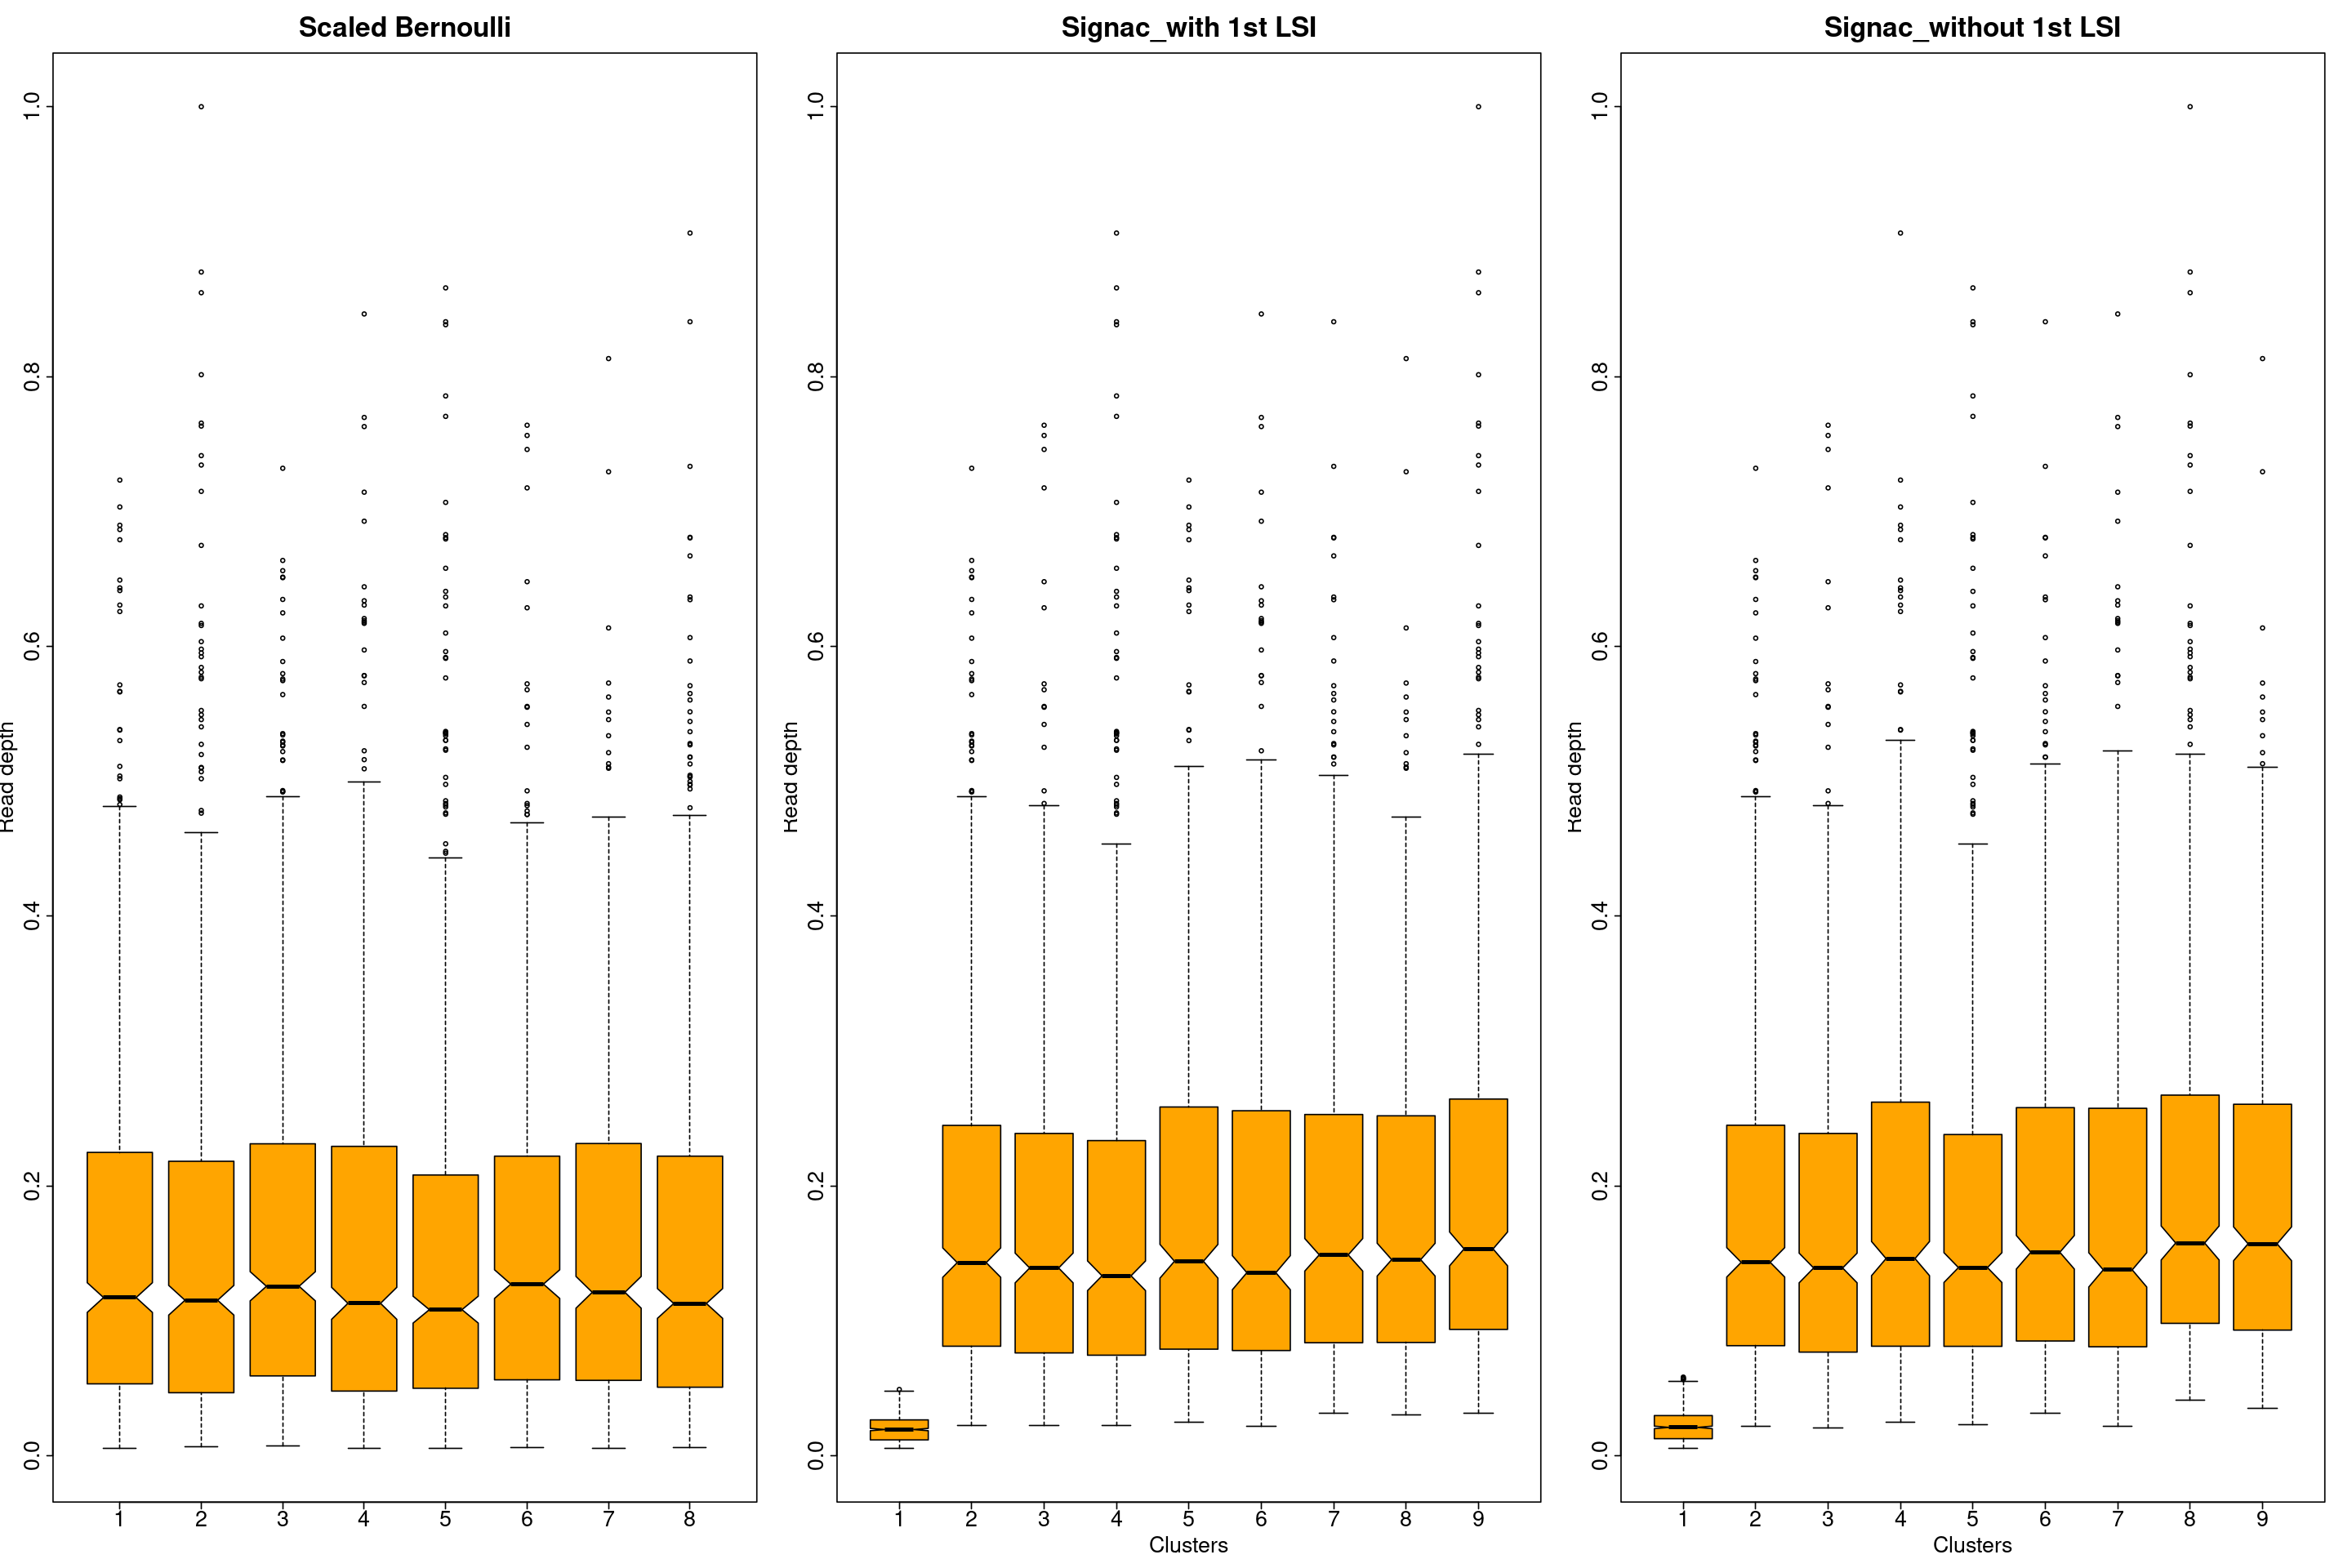

In [78]:
#par(mfrow=c(2,2) + 0.5)

layout(matrix(c(1,2,3), 1, 3, byrow = TRUE))

#barplot(t(dp_clusters_SB),
boxplot(t(dp_clusters_SB),
main = "Scaled Bernoulli",
#xlab = "Clusters",
ylab = "Read depth",
names.arg = 1:dim(dp_clusters_SB)[1],
col = "orange",
cex.axis = 2, cex.lab=2,cex.main=2.5,
notch = TRUE,
)


boxplot(t(dp_clusters_Seurat_with),
main = "Signac_with 1st LSI",
xlab = "Clusters",
ylab = "Read depth",
names.arg = 0:(dim(dp_clusters_Seurat_with)[1]-1),
col = "orange",
cex.axis = 2, cex.lab=2.0,cex.main=2.5,
notch = TRUE,
)

boxplot(t(dp_clusters_Seurat_without),
main = "Signac_without 1st LSI",
xlab = "Clusters",
ylab = "Read depth",
names.arg = 0:(dim(dp_clusters_Seurat_without)[1]-1),
col = "orange",
cex.axis = 2, cex.lab=2.0,cex.main=2.5,
notch = TRUE,
)